# Filter barcodes using knee point detection

# Introduction

We developed an algorithm to distinguish clone barcodes from erroneous sequences based on the distribution of read counts. Erroneous sequences can arise from residual PCR and sequencing errors that were not corrected by Starcode, resulting in sequences that are represented by few reads (in >99% of cases, only one read). To remove these sequences in an unbiased manner, we used a knee point filter similar to that used in 10X Genomics CellRanger 2.2. The knee point threshold was set to 1% of the 99th percentile of read abundance among the top N = 5,000 barcodes, where N is the expected maximum number of barcodes (here N = 5,000 because 5,000 cells per population were sorted into the well to initiate the experiment). Barcodes were further filtered to exclude those with fewer than 10 reads. To enhance overall detection sensitivity for clone barcodes having changing abundance (e.g. barcodes that went extinct), filtering was performed separately for each timepoint, then resulting calls for each barcode were propagated across timepoints, such that a barcode was excluded if and only if the filter excluded it at all timepoints (equivalently, a barcode was included as genuine if the filter included it at any timepoint).

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "."
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Counts of clone barcodes

Load barcodes with counts after merging barcodes based on sequence clustering (`clones.error_corrected.tsv.gz`).

In [4]:
infile = "../../../sequencing_data_preprocessing/population_dynamics/clones.error_corrected.tsv.gz"  # path to clones.error_corrected.tsv.gz

clones = pd.read_csv(infile, sep="\t", header=0, index_col=None)

print(clones.shape)
clones.head()

(4249646, 4)


,lib,library_barcode_call,clone_barcode_consensus,count
0,sFH11-1,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,565
1,sFH11-1,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,540
2,sFH11-1,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,491
3,sFH11-1,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,478
4,sFH11-1,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,461


# Preprocessing

## Filter for library barcodes in experiment

In [5]:
# Select subset of barcodes that are present in experiment

clones = clones.loc[clones["library_barcode_call"].isin(["LB1", "LB2"])]

print(clones.shape)
clones.head()

(4229949, 4)


,lib,library_barcode_call,clone_barcode_consensus,count
0,sFH11-1,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,565
1,sFH11-1,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,540
2,sFH11-1,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,491
3,sFH11-1,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,478
4,sFH11-1,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,461


## Add sample metadata (time of harvest, well, type of sample)

In [6]:
# Set library order

libs_ordered = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7",
                "sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14",
                "sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21",
                "sFH12-9", "sFH12-10", "sFH12-11", "sFH12-12", "sFH12-13", "sFH12-14"]

libs_ordered_supernatant = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7",
                            "sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14",
                            "sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21"]

libs_ordered_cells = ["sFH12-9", "sFH12-10", "sFH12-11", "sFH12-12", "sFH12-13", "sFH12-14"]

libs_ordered_by_well = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7", "sFH12-9", "sFH12-10",
                        "sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14", "sFH12-11", "sFH12-12",
                        "sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21", "sFH12-13", "sFH12-14"]

libs_ordered_fidelity = ["sFH11-6", "sFH11-7", "sFH12-9", "sFH12-10", "sFH11-13", "sFH11-14", "sFH12-11", "sFH12-12", "sFH11-20", "sFH11-21", "sFH12-13", "sFH12-14"]

In [7]:
# Map library to time of harvest (days)
lib_to_time = {"sFH11-1": 0,
                "sFH11-2": 1,
                "sFH11-3": 2,
                "sFH11-4": 3,
                "sFH11-5": 4,
                "sFH11-6": 5,
                "sFH11-7": 5,
                "sFH11-8": 0,
                "sFH11-9": 1,
                "sFH11-10": 2,
                "sFH11-11": 3,
                "sFH11-12": 4,
                "sFH11-13": 5,
                "sFH11-14": 5,
                "sFH11-15": 0,
                "sFH11-16": 1,
                "sFH11-17": 2,
                "sFH11-18": 3,
                "sFH11-19": 4,
                "sFH11-20": 5,
                "sFH11-21": 5,
                "sFH12-9": 5,
                "sFH12-10": 5,
                "sFH12-11": 5,
                "sFH12-12": 5,
                "sFH12-13": 5,
                "sFH12-14": 5}

# Set time
clones["time"] = [lib_to_time[x] for x in clones["lib"]]

In [8]:
# Set well (used to select samples which should share barcodes)

clones["well"] = np.nan

selector = clones["lib"].isin(["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7", "sFH12-9", "sFH12-10"])
clones.loc[selector, "well"] = "puro"

selector = clones["lib"].isin(["sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14", "sFH12-11", "sFH12-12"])
clones.loc[selector, "well"] = "zeo"

selector = clones["lib"].isin(["sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21", "sFH12-13", "sFH12-14"])
clones.loc[selector, "well"] = "no_drug"

In [9]:
# Set cells or supernatant (used to select samples which should share barcodes)

clones["supernatant_or_cells"] = np.nan

selector = clones["lib"].isin(libs_ordered_supernatant)
clones.loc[selector, "supernatant_or_cells"] = "supernatant"

selector = clones["lib"].isin(libs_ordered_cells)
clones.loc[selector, "supernatant_or_cells"] = "cells"

# Define functions for calling and plotting

In [10]:
def rankplot_call_by_cutoff(ax, barcodes, field,
                            libs, library_barcode_calls,
                            num_clones_expected, labels,
                            palette, palette_background,
                            COUNTS_CUTOFF=10,
                            N_RANK_CUTOFF=10000):

    for lib, library_barcode_call, n_expected, label, color, color_background in zip(libs, library_barcode_calls, num_clones_expected, labels, palette, palette_background):
        
        selector = (barcodes["lib"] == lib) & (barcodes["library_barcode_call"] == library_barcode_call)
        counts = barcodes.loc[selector][field].value_counts().reset_index()[field]  # Calculate counts per field

        if counts.shape[0] == 0:
            print("Warning: counts.shape[0] == 0 (empty count list).")
            continue
        
        counts_subset = counts.head(n=N_RANK_CUTOFF)  # take top N_RANK_CUTOFF
        
        counts_called = counts_subset[counts_subset > COUNTS_CUTOFF]  # called as clone barcodes
        counts_background = counts_subset[counts_subset < COUNTS_CUTOFF]  # called as background
        counts_background = pd.concat([counts_called.tail(n=1), counts_background])  # concatenate final count of called to make line continuous

        # Plot counts called as clones
        x = counts_called.index+1  # rank
        y = counts_called
        sns.lineplot(ax=ax, x=x, y=y, color=color, zorder=10)
        g = sns.scatterplot(ax=ax, x=x, y=y, marker="o", edgecolor=None, label=label, color=color, zorder=20)

        # Plot counts called as background
        x = counts_background.index+1  # rank
        y = counts_background
        sns.lineplot(ax=ax, x=x, y=y, color=color_background, zorder=1)

    return g

In [11]:
def find_shoulder_cutoff(counts, N=1000, Q=99, D=10, exclude_top=False):    
    """ Find shoulder of barcode rank plot
    
    Algorithm is adapted from 10X Genomics Cellranger cell barcode identification.
    
    Let N be the expected number of recovered clones.
    Let M be the Qth percentile of the top N barcodes by total read counts, after excluding the top read count. Q is typically 99th percentile.
    Let D be the expected dynamic range of read counts. D is typically 10 - 100.
    
    Then the cutoff count at shoulder is C = M/D.
    
    All barcodes whose total read counts exceed C are called as clones.
    
    Note that we exclude the top read count because it is STD, which always dominates the rest.
    
    Requires N >= 2 (because we drop top read count). If expected number of recovered clones is 1, use N = 2.
    
    """
    if exclude_top:
        C = np.percentile(counts.head(n=N).tail(n=N-1), q=Q) / D
    else:
        C = np.percentile(counts.head(n=N), q=Q) / D
    return C

In [12]:
def rankplot_shoulder(ax, barcodes, field,
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=99,
                      D_DYNAMIC_RANGE_EXPECTED=20,
                      N_RANK_CUTOFF=10000):

    for lib, library_barcode_call, n_expected, label, color, color_background in zip(libs, library_barcode_calls, num_clones_expected, labels, palette, palette_background):
        
        selector = (barcodes["lib"] == lib) & (barcodes["library_barcode_call"] == library_barcode_call)
        counts = barcodes.loc[selector][field]  # Get counts per clone
        counts = counts.reset_index(drop=True)

        if counts.shape[0] == 0:
            print("Warning: counts.shape[0] == 0 (empty count list).")
            continue

        shoulder_cutoff = find_shoulder_cutoff(counts, N=n_expected, Q=Q_TOP_PERCENTILE, D=D_DYNAMIC_RANGE_EXPECTED)

        counts_subset = counts.head(n=N_RANK_CUTOFF)  # take top N_RANK_CUTOFF
        counts_called = counts_subset[counts_subset > shoulder_cutoff]  # called as clone barcodes
        counts_background = counts_subset[counts_subset < shoulder_cutoff]  # called as background

        counts_background = pd.concat([counts_called.tail(n=1), counts_background])  # concatenate final count of called to make line continuous

        # Plot counts called as clones
        x = counts_called.index+1  # rank
        y = counts_called
        sns.lineplot(ax=ax, x=x, y=y, color=color, zorder=10)
        g = sns.scatterplot(ax=ax, x=x, y=y, marker="o", edgecolor=None, label=label, color=color, zorder=20)

        # Plot counts called as background
        x = counts_background.index+1  # rank
        y = counts_background
        sns.lineplot(ax=ax, x=x, y=y, color=color_background, zorder=1)

    return g

# Show examples of calling

## Set parameters for calling and plotting

In [13]:
# Set parameters for shoulder detection
Q_TOP_PERCENTILE = 99  # percentile of top N barcodes by reads Q
D_DYNAMIC_RANGE_EXPECTED = 100  # expected dynamic range of barcode counts D
# D_DYNAMIC_RANGE_EXPECTED = 20  # expected dynamic range of barcode counts D

In [14]:
# Set palette
# palette = ['#e6550d','#9970ab','#c2a5cf', '#a6dba0','#5aae61','#1b7837']

palette = ['#440154','#443983','#31688e', '#21918c','#35b779','#90d743','#fde725']
palette_background = ['#d9d9d9', '#bdbdbd','#969696','#737373','#525252','#252525','#000000'][::-1]

palette_cells = ["#9e9ac8", "#54278f", "#bae4b3", "#31a354"]

# Set parameters for plot
N_RANK_CUTOFF = 100000  # maximum rank displayed

## Show example of dynamics library collection (supernatant over time)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


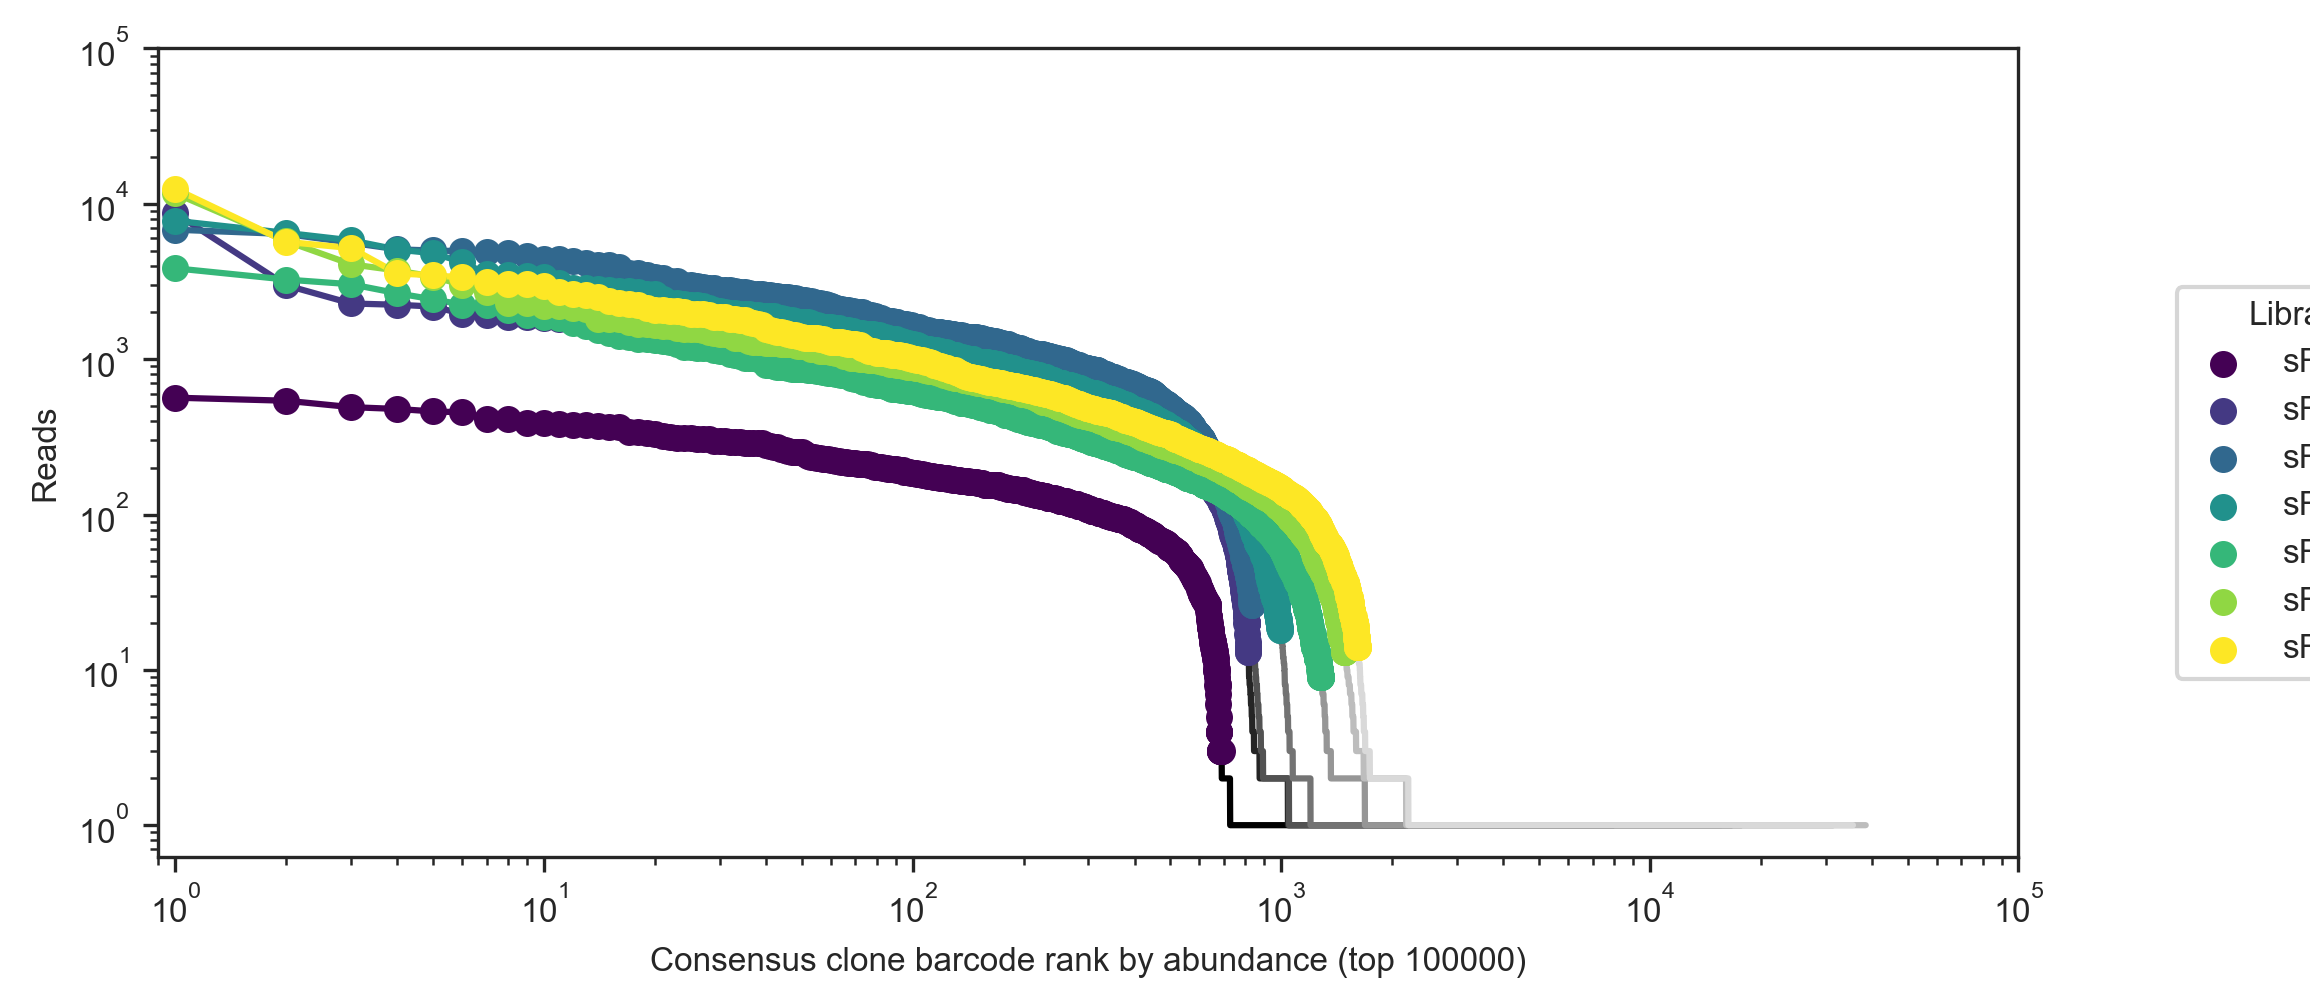

In [15]:
libs = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7"]
library_barcode_calls = ["LB1"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

## Show example of fidelity library collection (cells at endpoint)

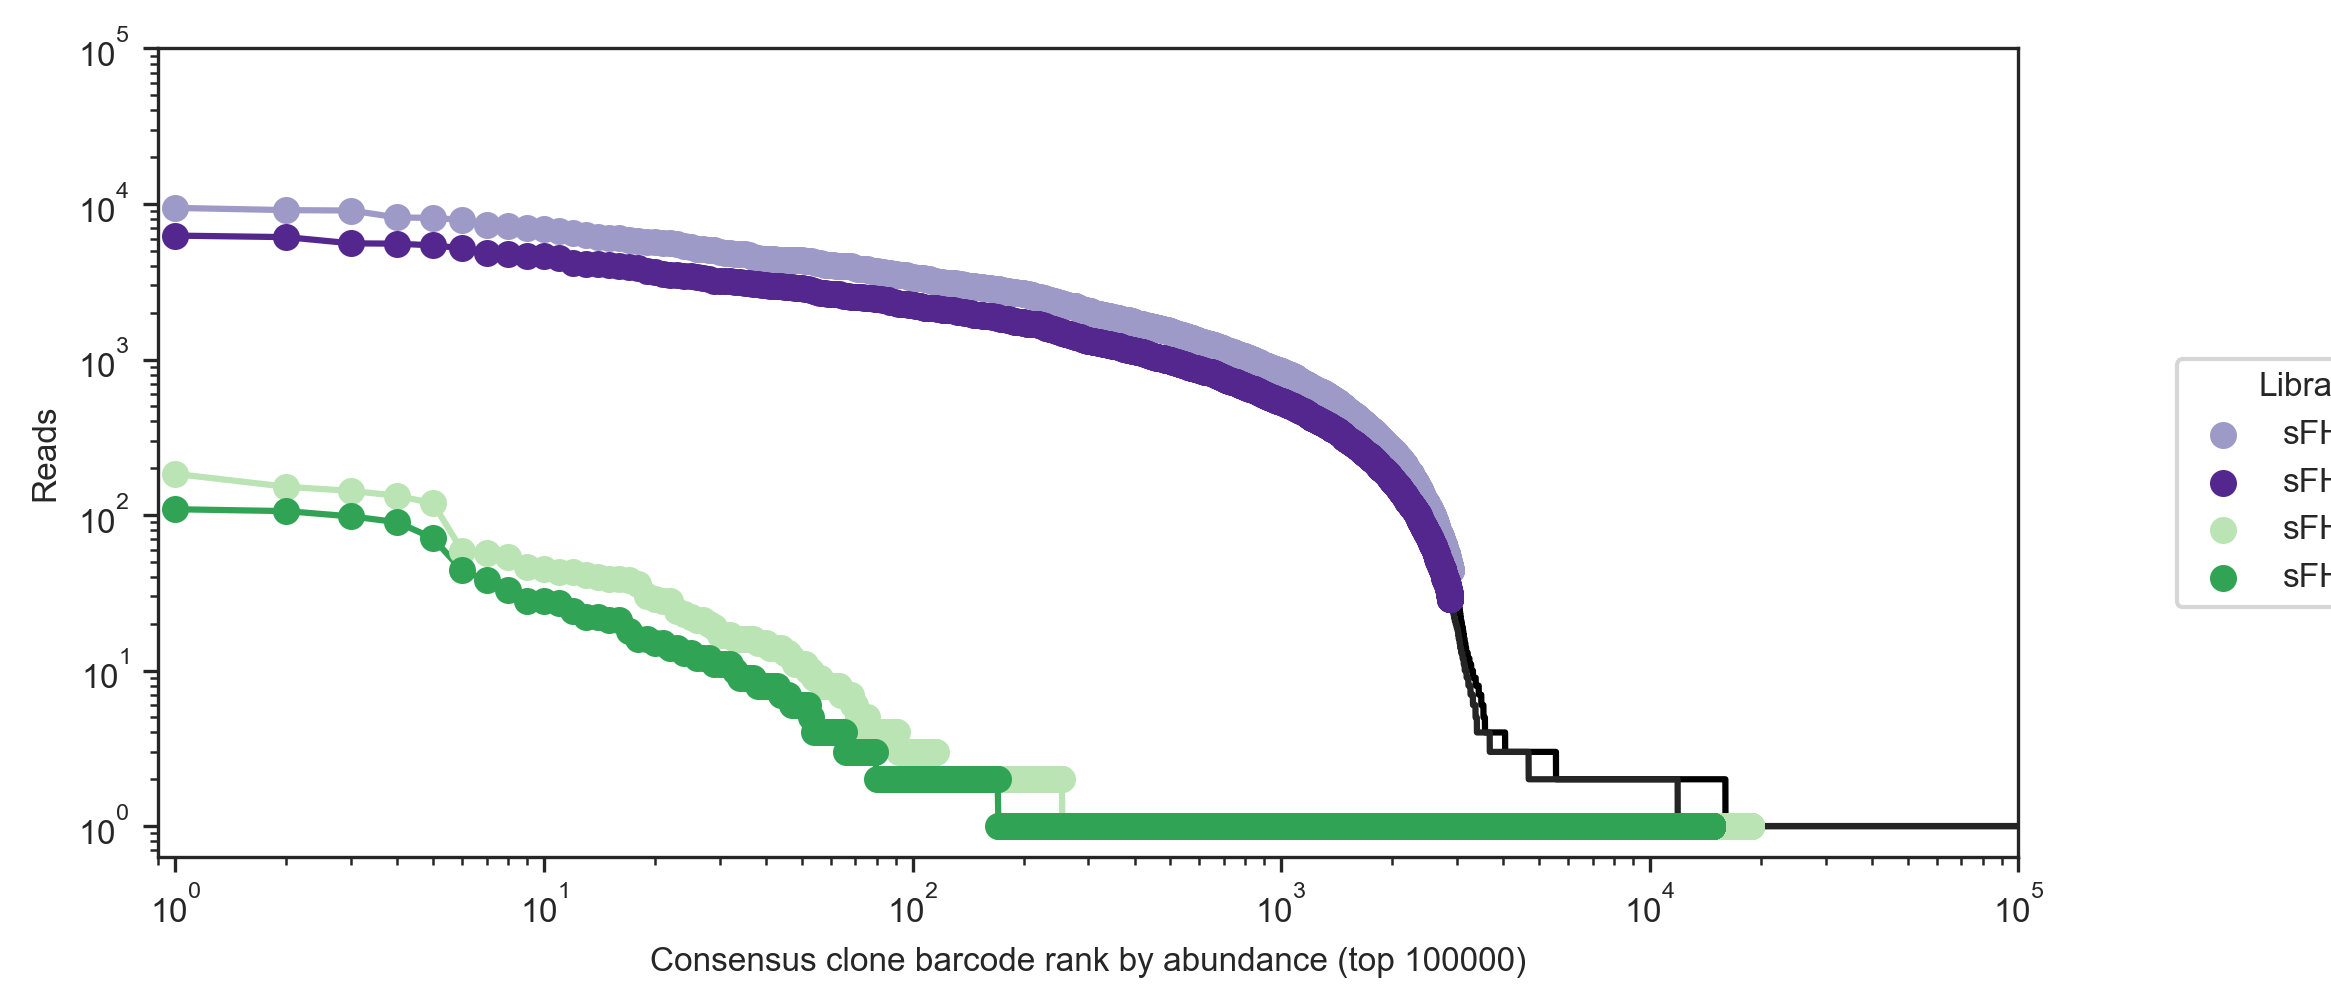

In [16]:
libs = ["sFH12-9", "sFH12-10", "sFH12-9", "sFH12-10"]
library_barcode_calls = ["LB1", "LB1", "LB2", "LB2"]

num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette_cells, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

# Plot genuine barcodes to visualize calling

## Dynamics (supernatant)

### Puro selection

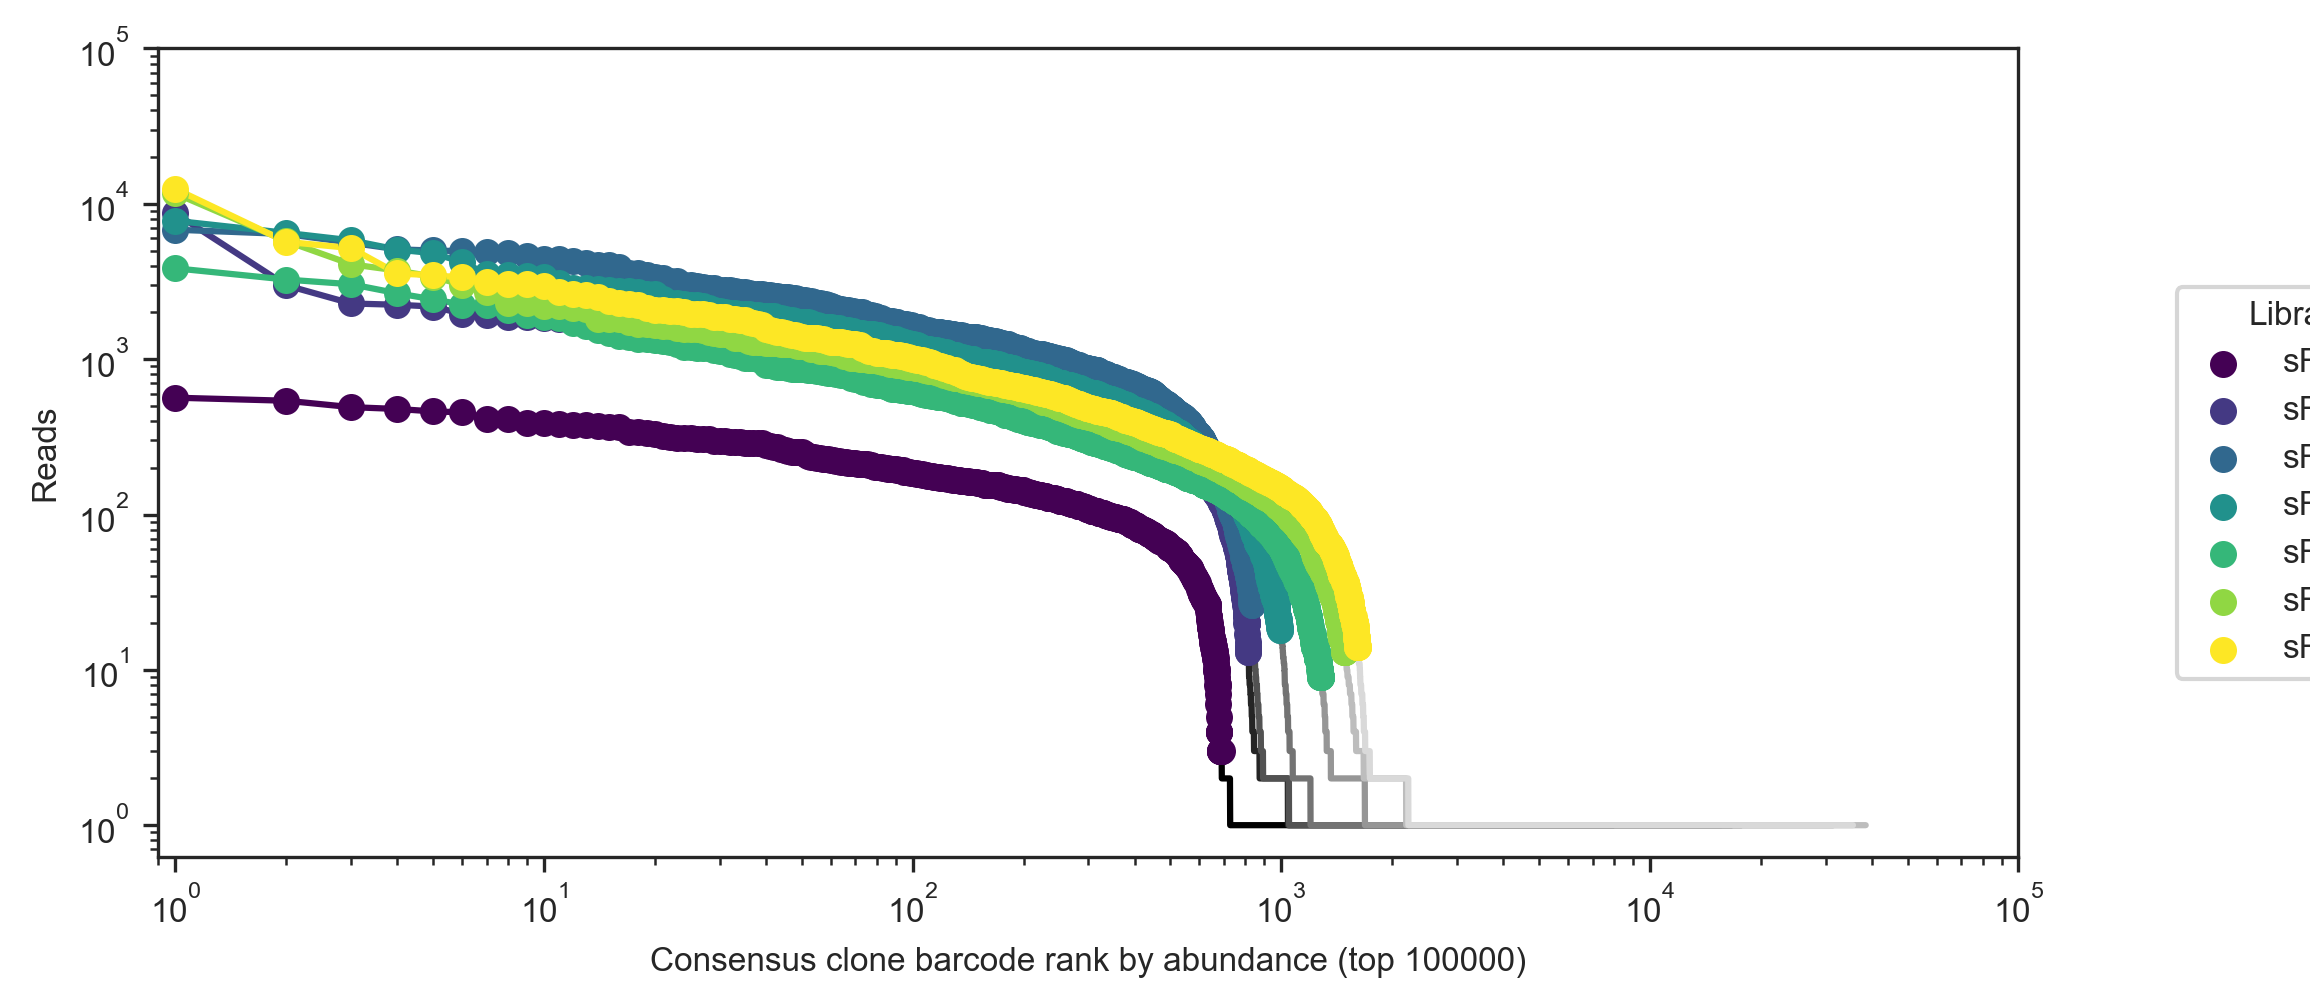

In [17]:
libs = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7"]
library_barcode_calls = ["LB1"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

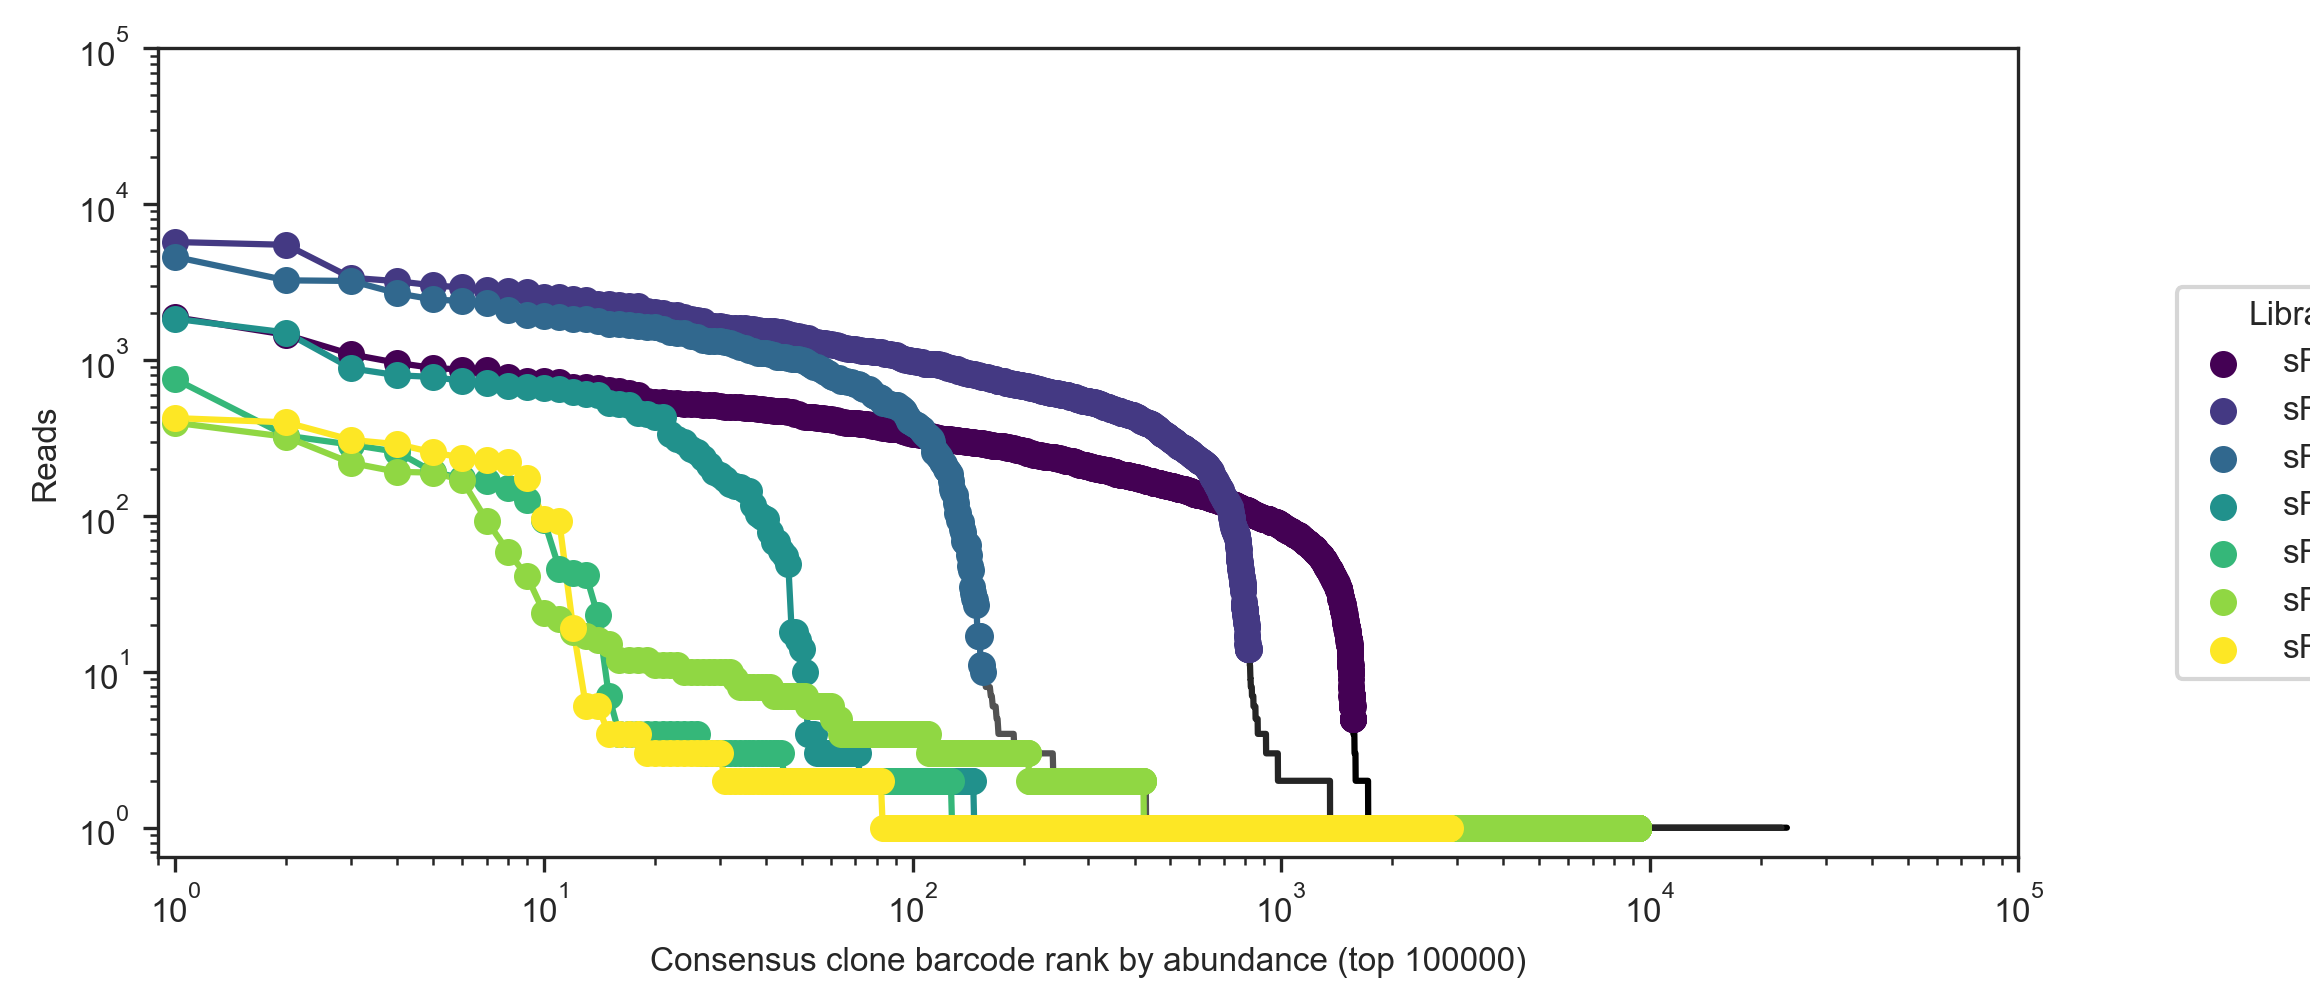

In [18]:
libs = ["sFH11-1", "sFH11-2", "sFH11-3", "sFH11-4", "sFH11-5", "sFH11-6", "sFH11-7"]
library_barcode_calls = ["LB2"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

### Zeo selection

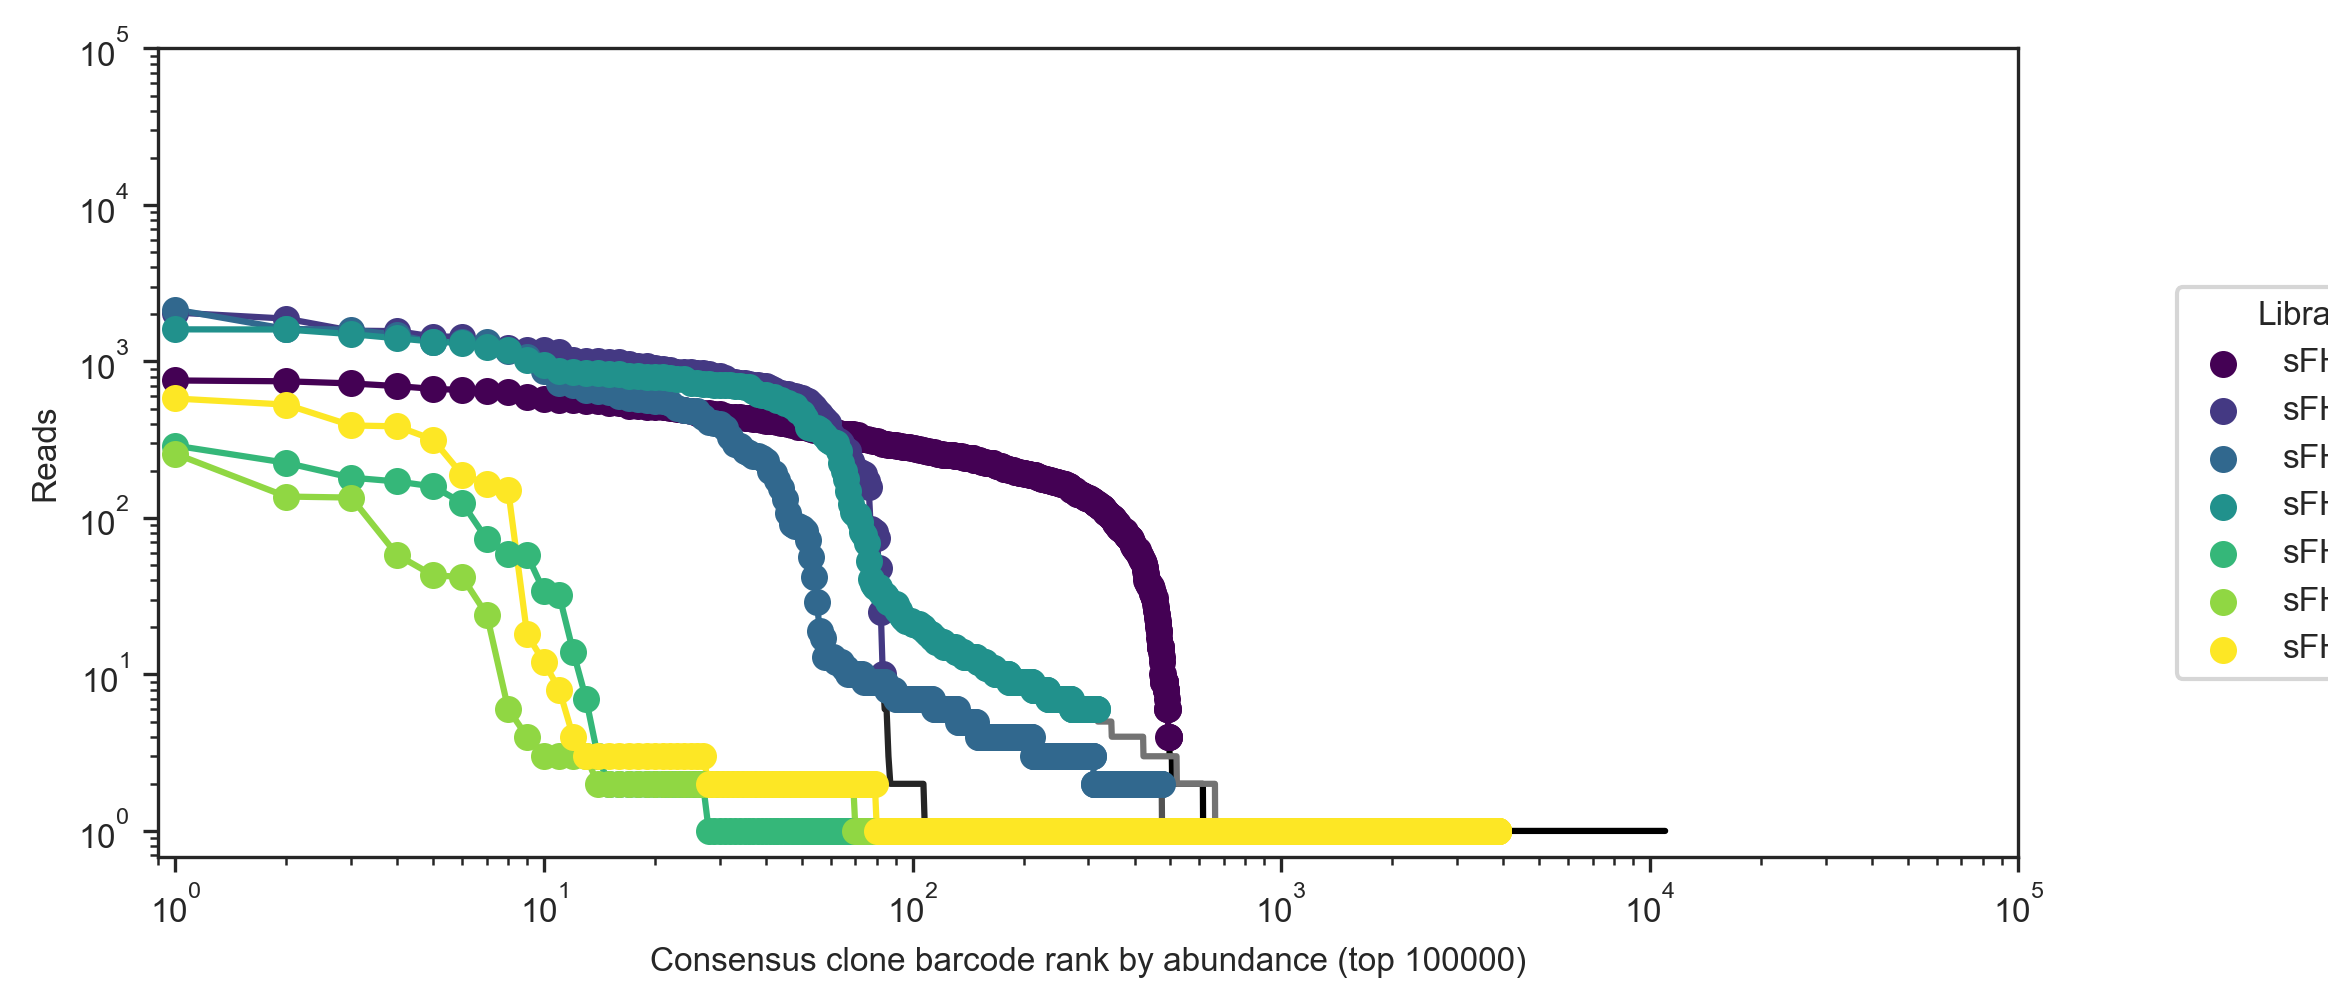

In [19]:
libs = ["sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14"]
library_barcode_calls = ["LB1"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

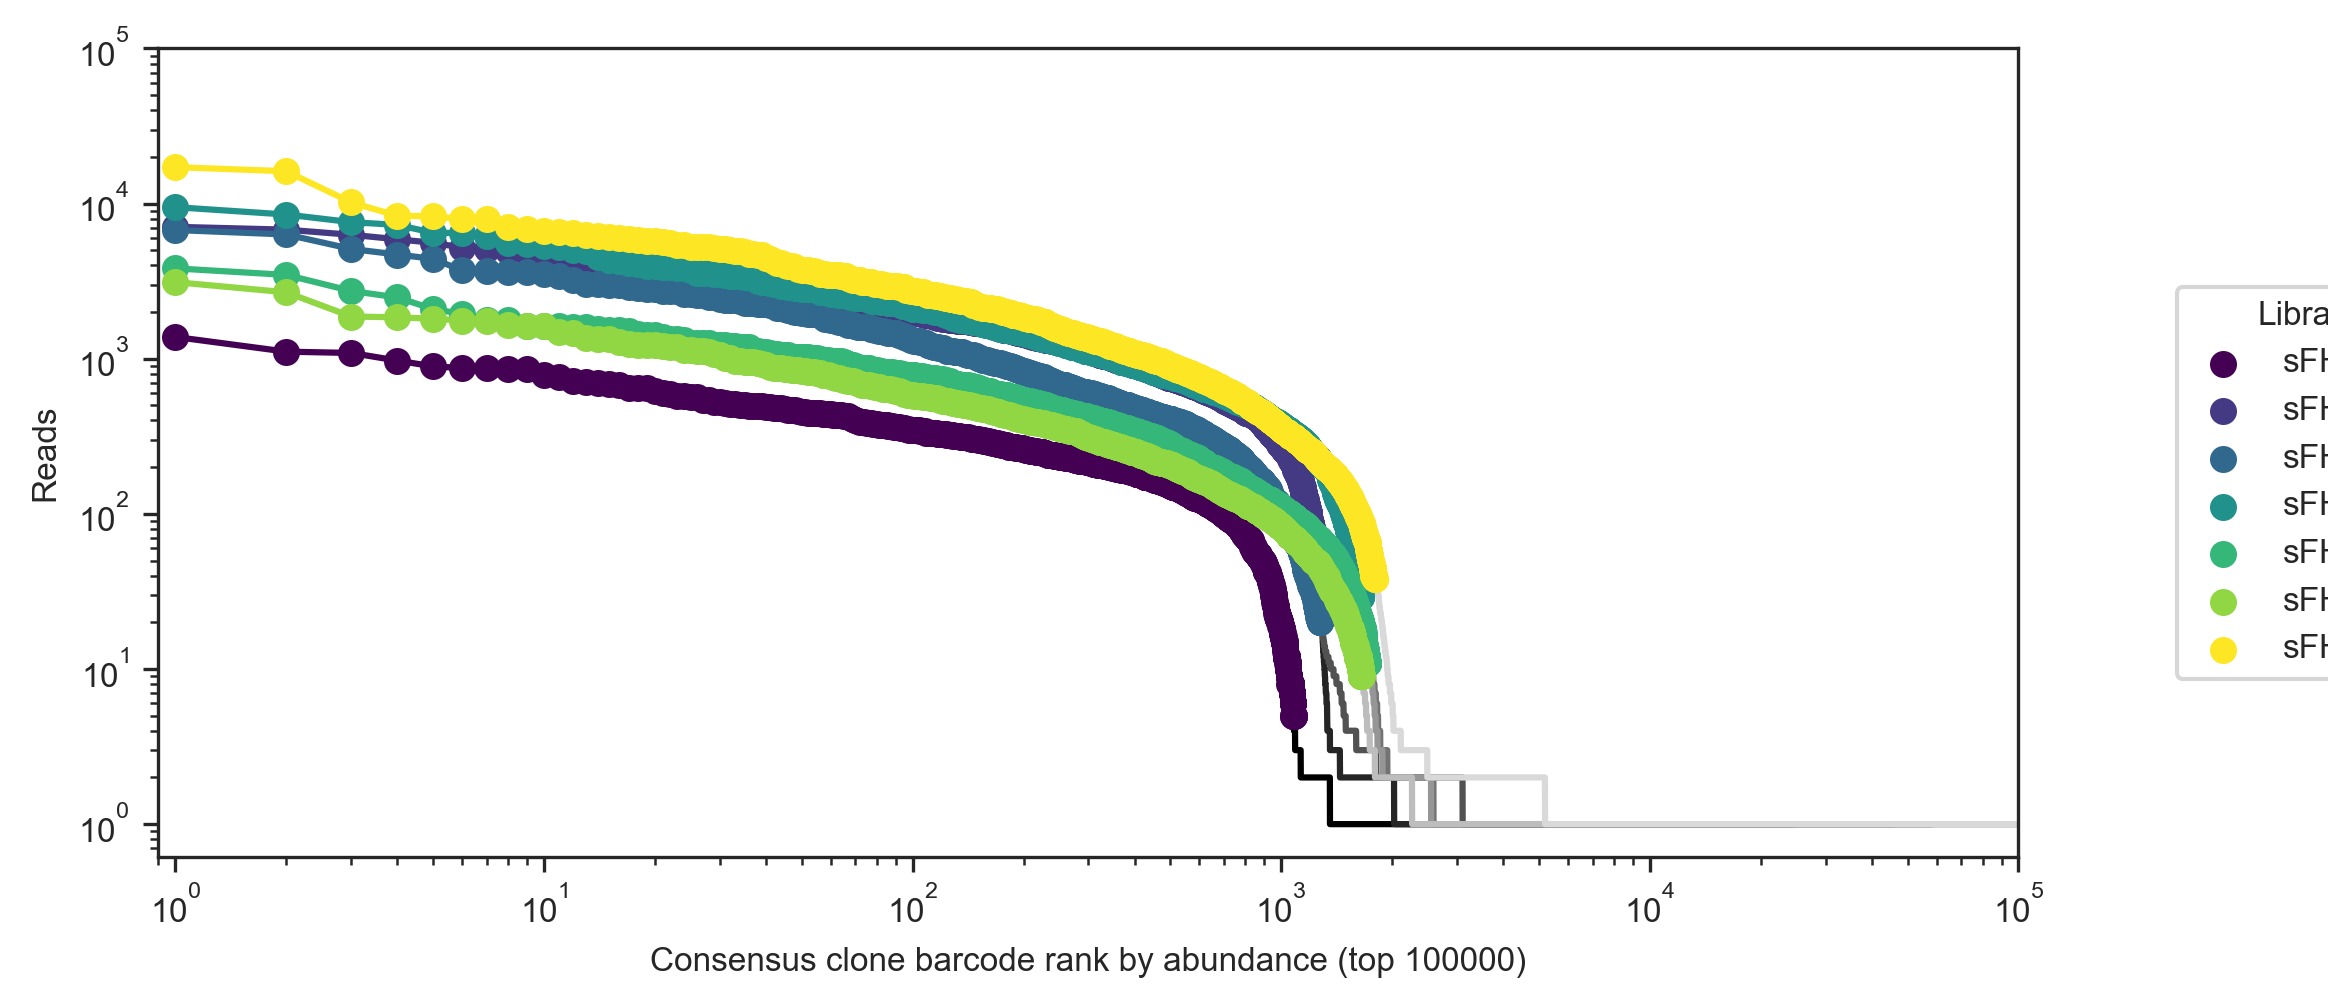

In [20]:
libs = ["sFH11-8", "sFH11-9", "sFH11-10", "sFH11-11", "sFH11-12", "sFH11-13", "sFH11-14"]
library_barcode_calls = ["LB2"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

### No drug

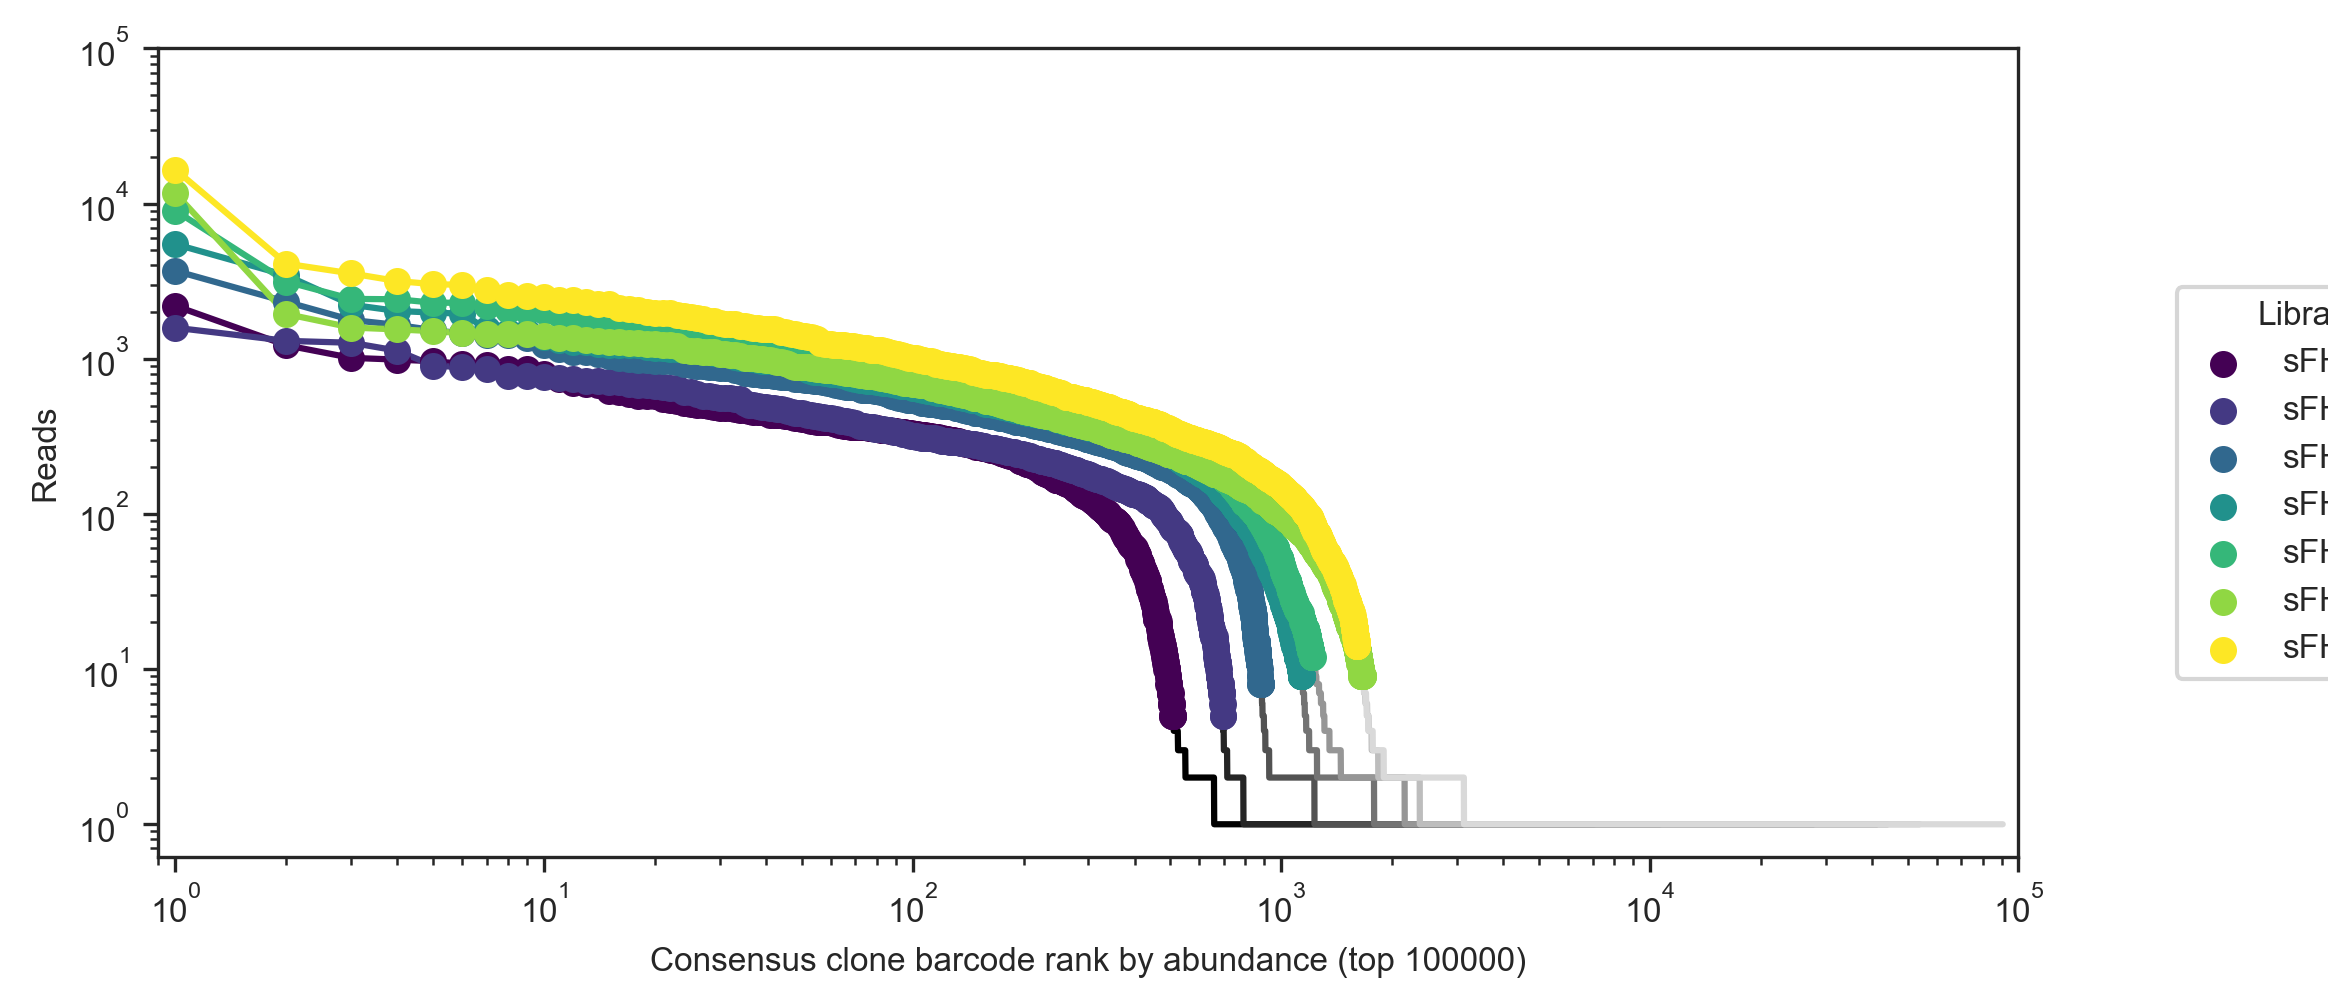

In [21]:
libs = ["sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21"]
library_barcode_calls = ["LB1"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

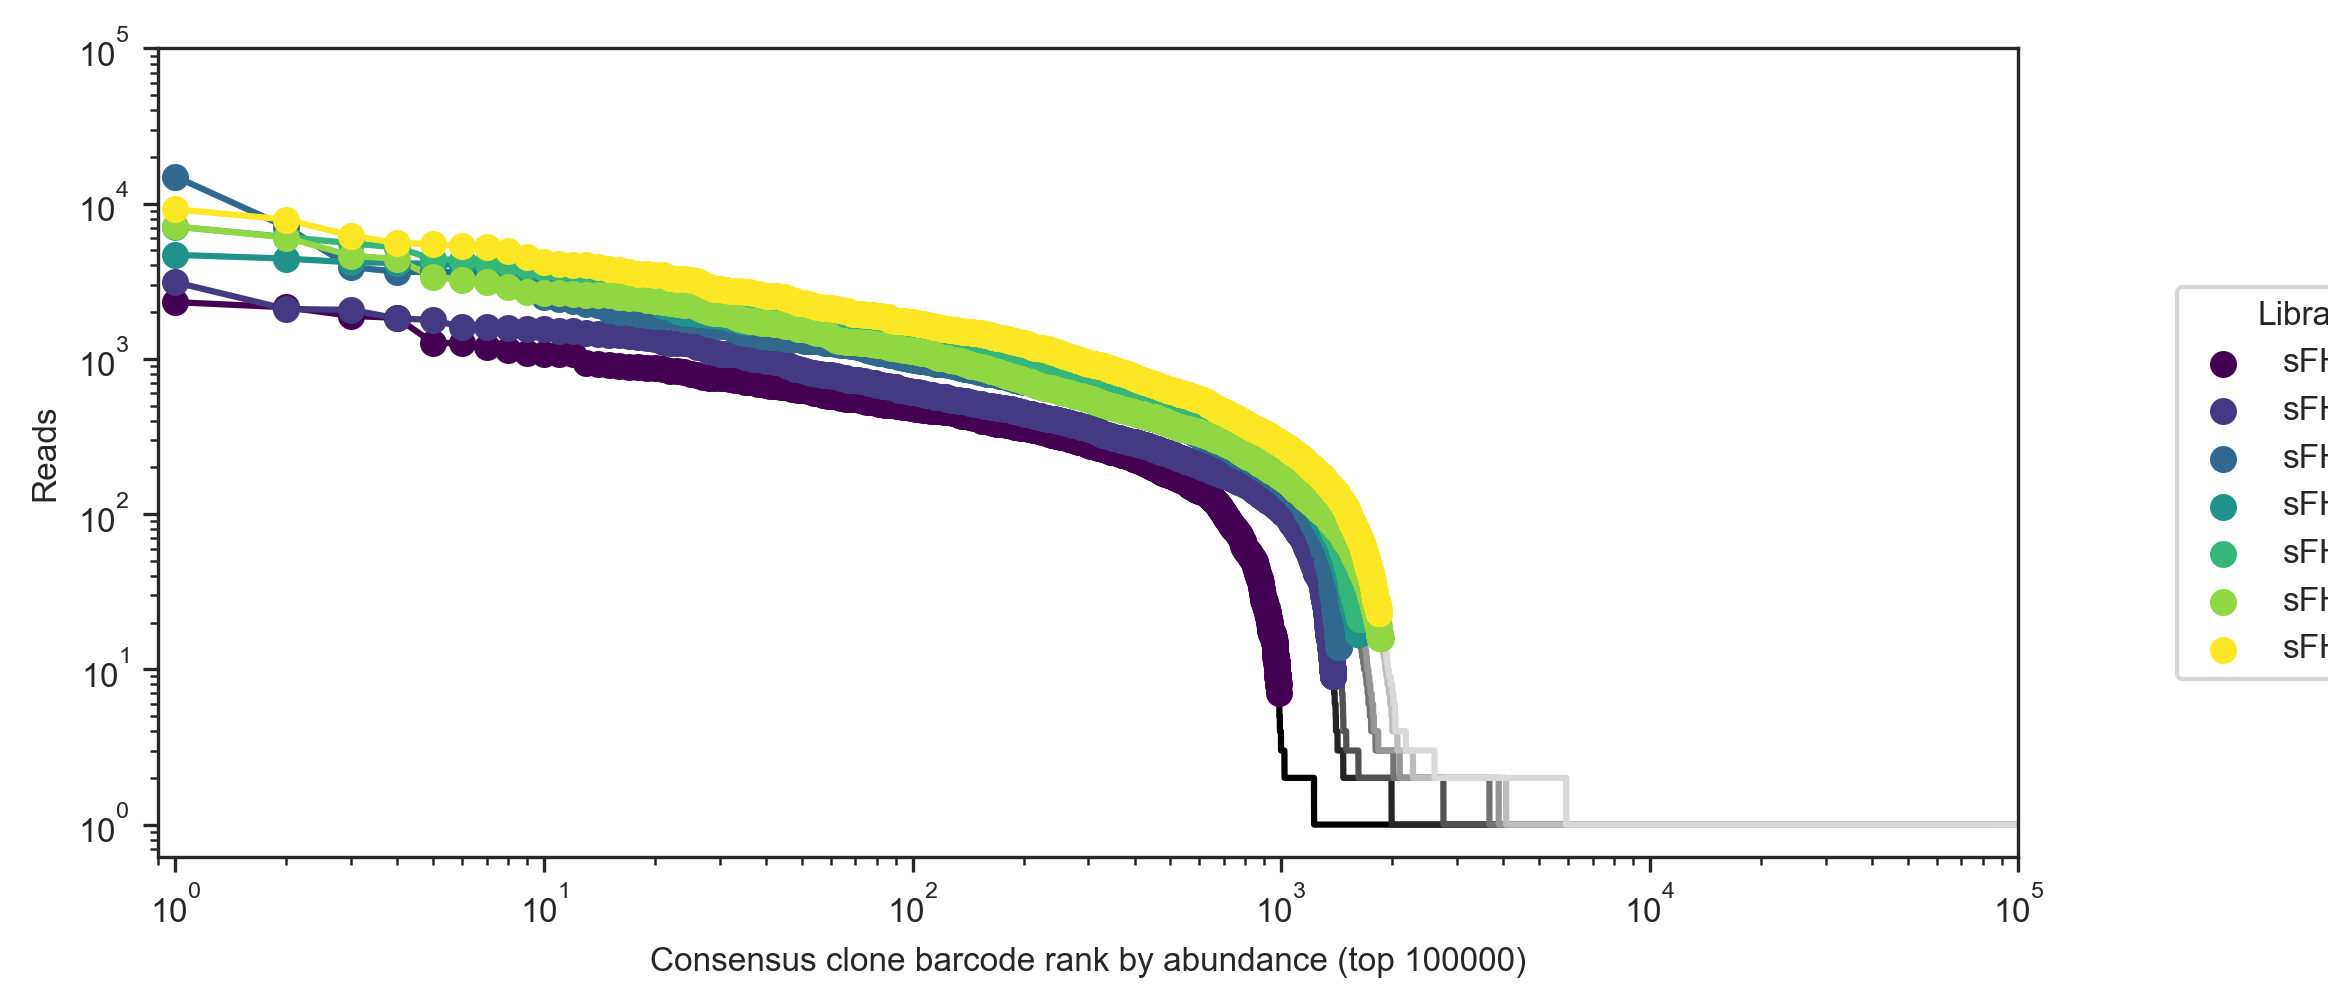

In [22]:
libs = ["sFH11-15", "sFH11-16", "sFH11-17", "sFH11-18", "sFH11-19", "sFH11-20", "sFH11-21"]
library_barcode_calls = ["LB2"] * len(libs)
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = libs

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

## Fidelity (cells)

### Puro selection

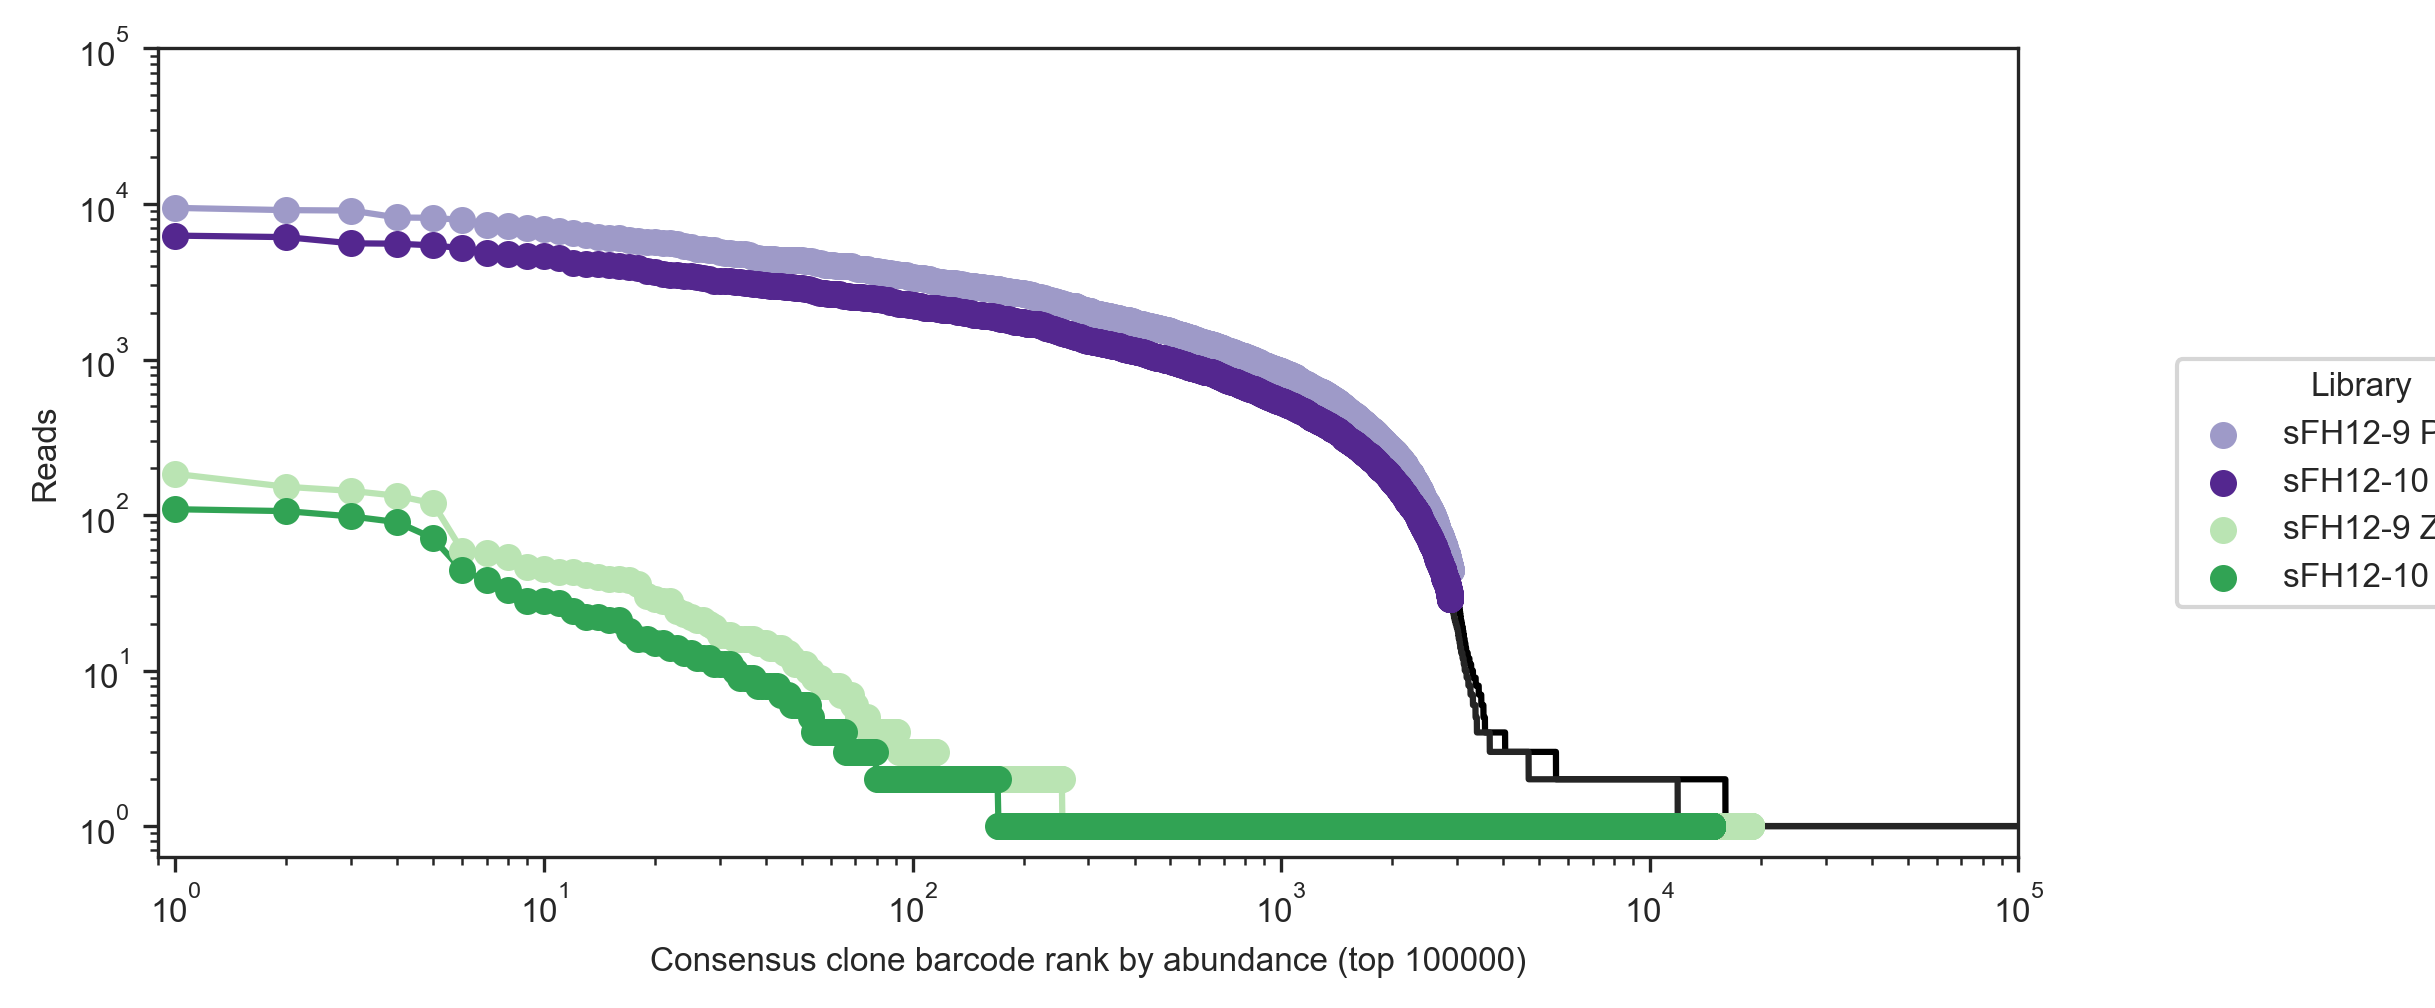

In [23]:
libs = ["sFH12-9", "sFH12-10", "sFH12-9", "sFH12-10"]
library_barcode_calls = ["LB1", "LB1", "LB2", "LB2"]
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = ["sFH12-9 PuroR", "sFH12-10 PuroR", "sFH12-9 ZeoR", "sFH12-10 ZeoR"]

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette_cells, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

### Zeo selection

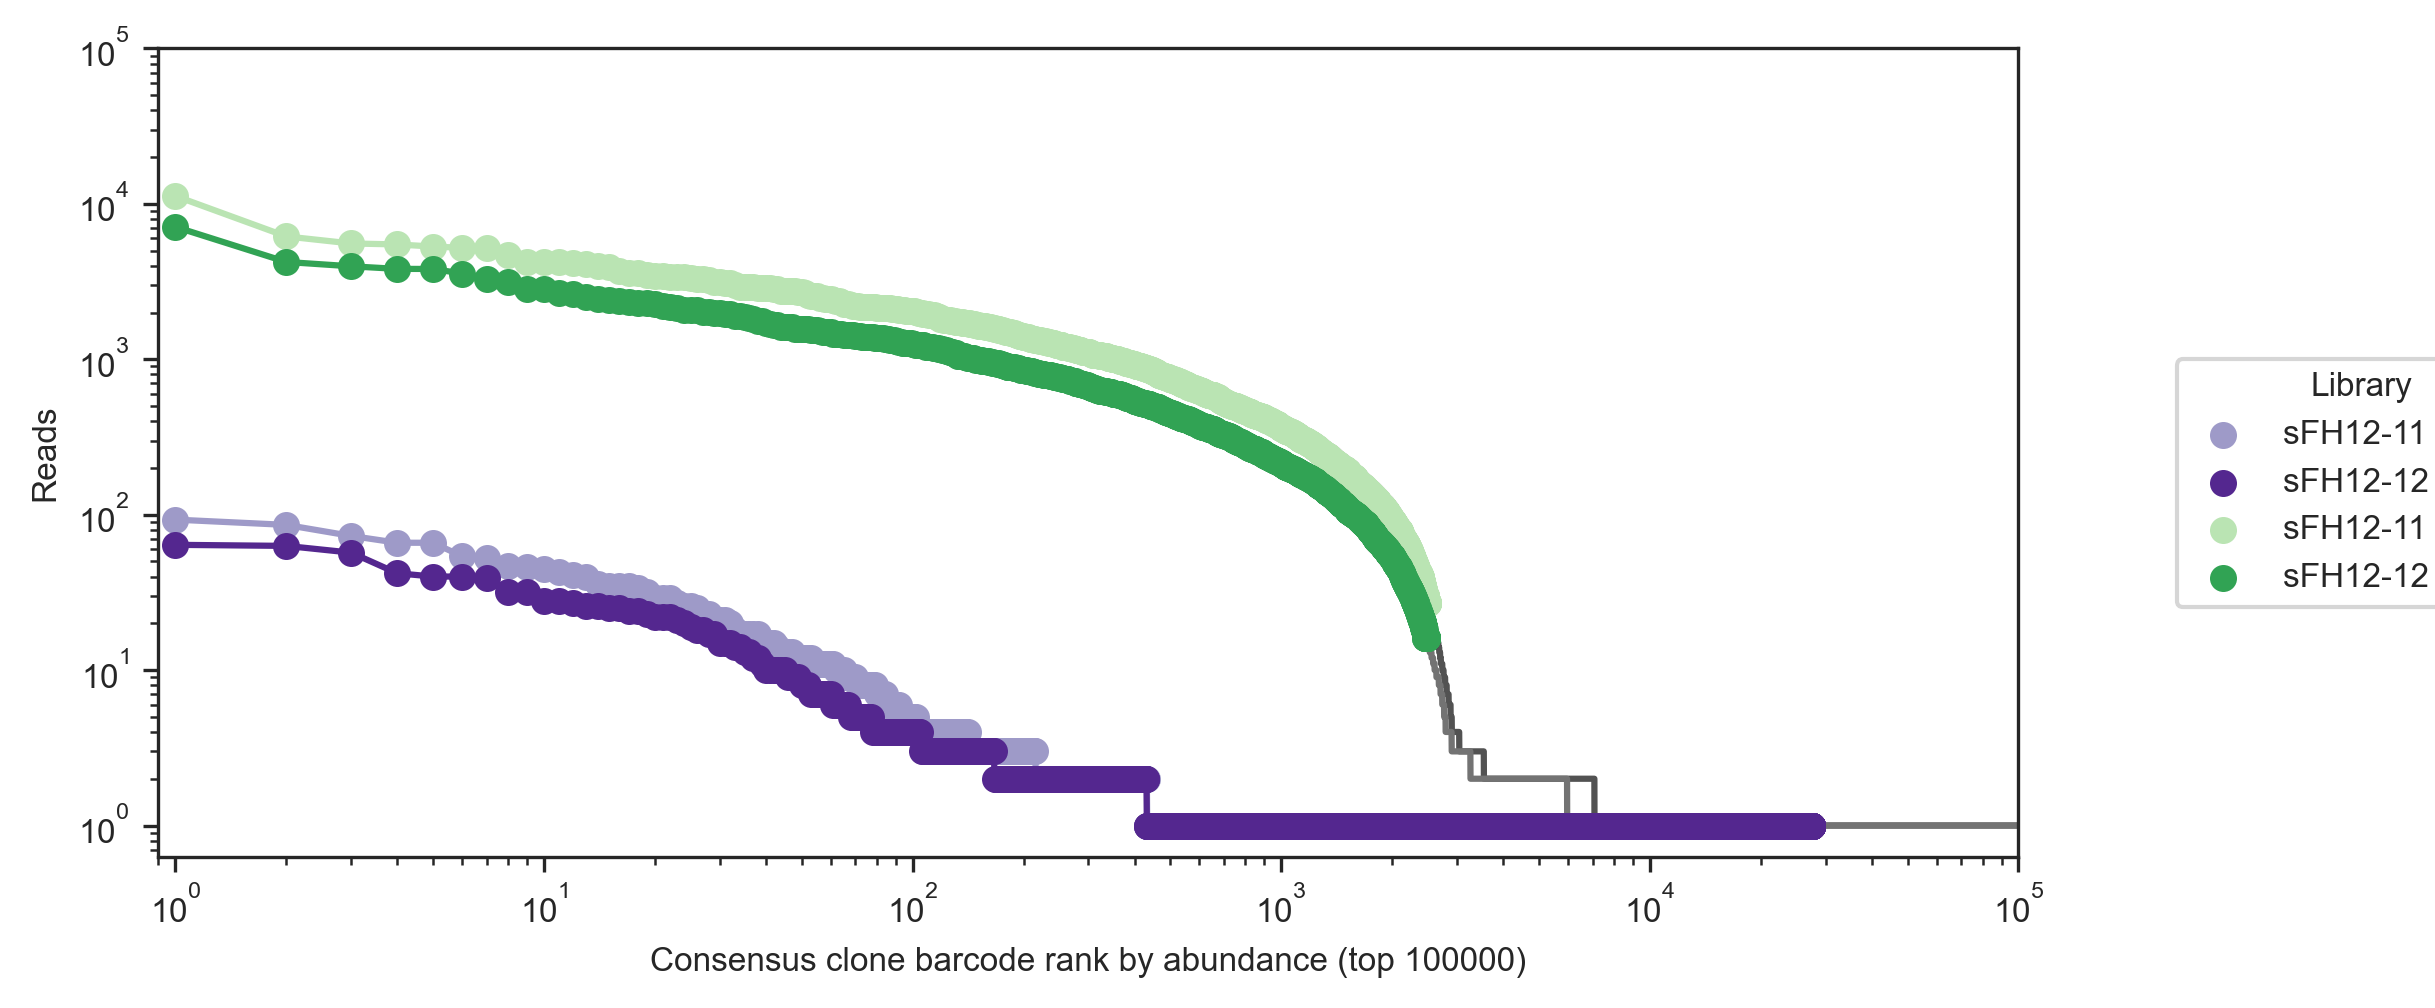

In [24]:
libs = ["sFH12-11", "sFH12-12", "sFH12-11", "sFH12-12"]
library_barcode_calls = ["LB1", "LB1", "LB2", "LB2"]
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = ["sFH12-11 PuroR", "sFH12-12 PuroR", "sFH12-11 ZeoR", "sFH12-12 ZeoR"]

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette_cells, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

### No drug

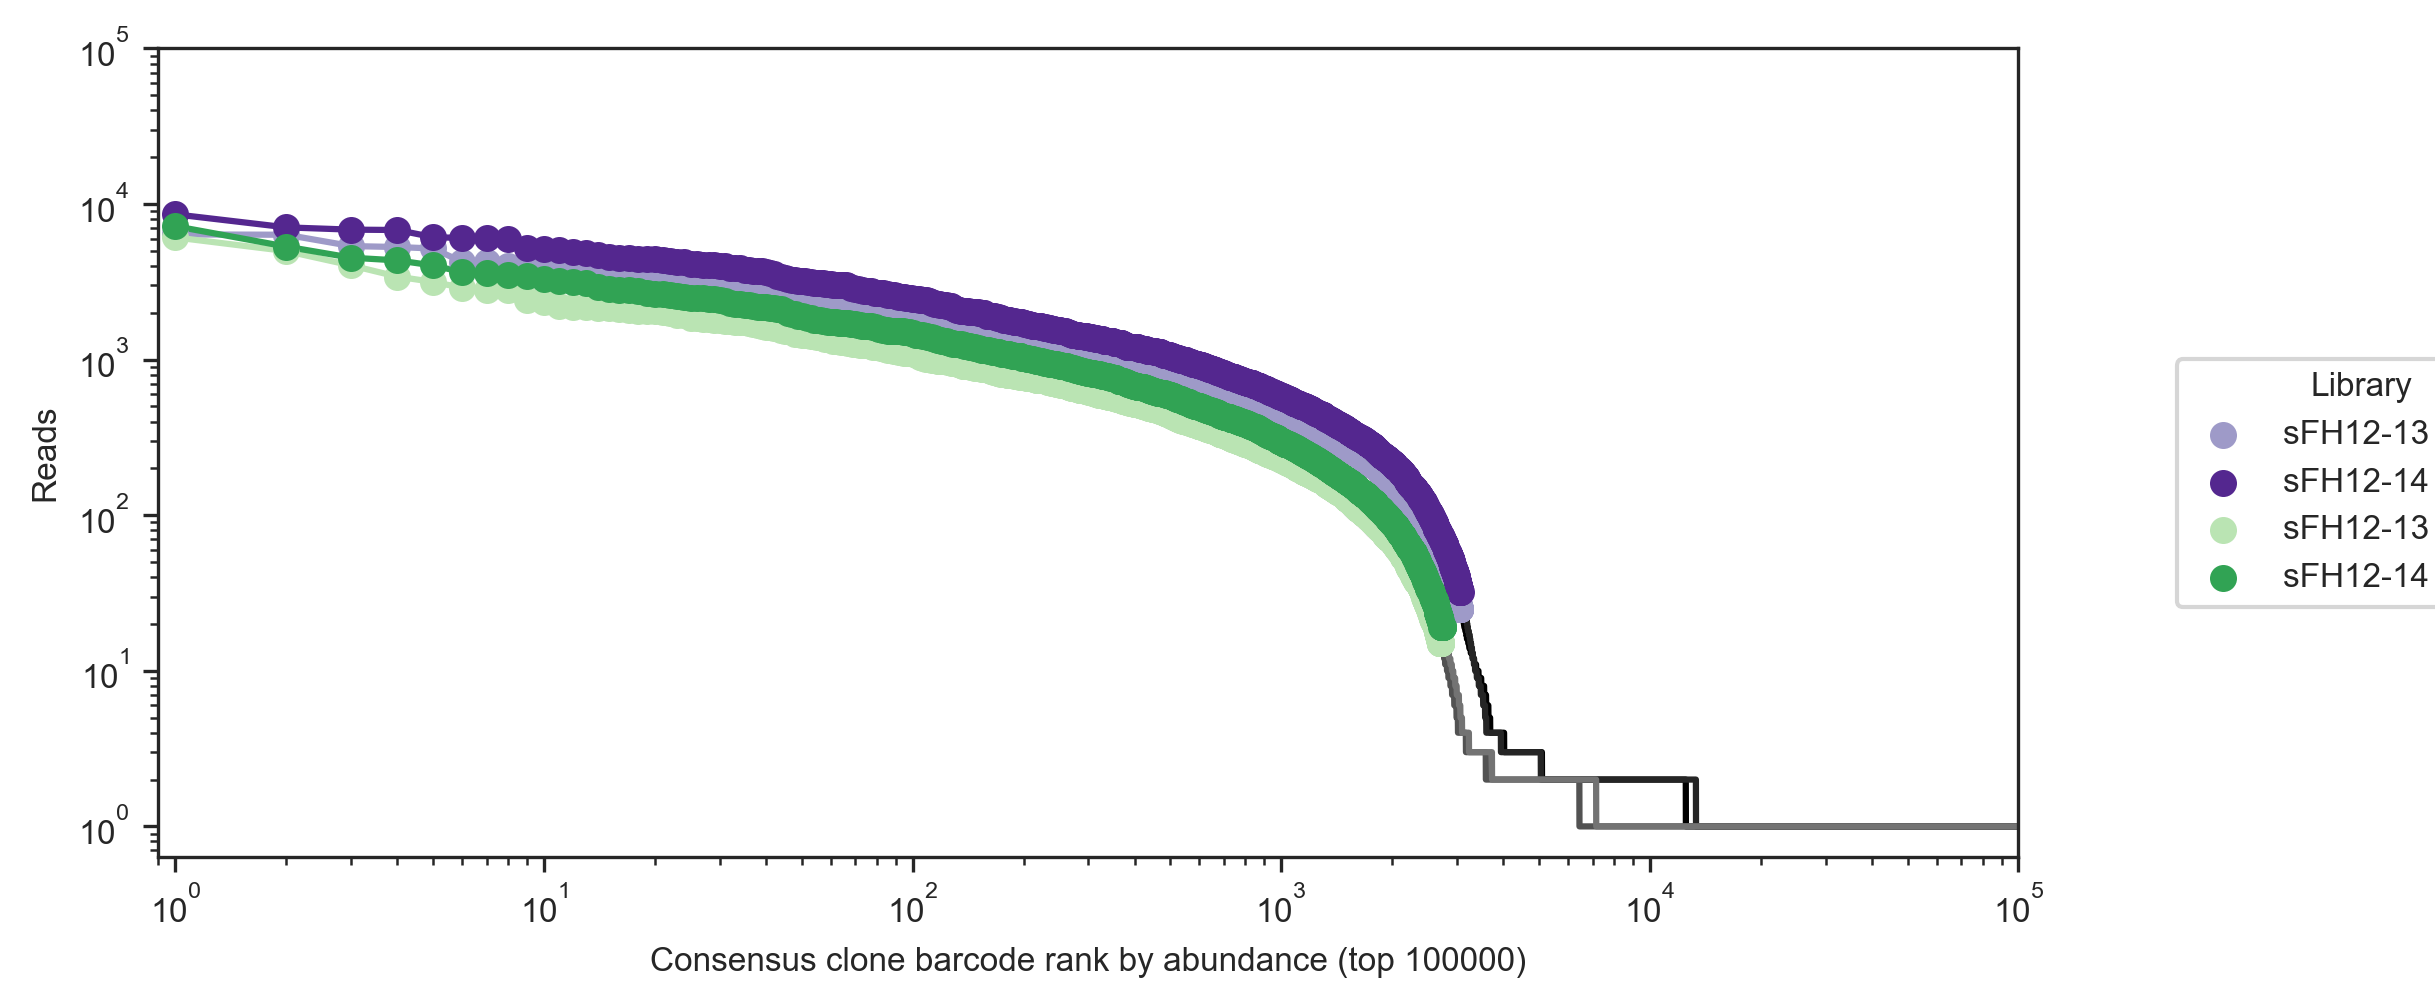

In [25]:
libs = ["sFH12-13", "sFH12-14", "sFH12-13", "sFH12-14"]
library_barcode_calls = ["LB1", "LB1", "LB2", "LB2"]
num_clones_expected = [5000] * len(libs)  # number of clones expected
labels = ["sFH12-13 PuroR", "sFH12-14 PuroR", "sFH12-13 ZeoR", "sFH12-14 ZeoR"]

fig, ax = plt.subplots(1, 1, figsize=(8,3.5))

g = rankplot_shoulder(ax, clones, "count",
                      libs, library_barcode_calls,
                      num_clones_expected, labels,
                      palette_cells, palette_background,
                      Q_TOP_PERCENTILE=Q_TOP_PERCENTILE,
                      D_DYNAMIC_RANGE_EXPECTED=D_DYNAMIC_RANGE_EXPECTED,
                      N_RANK_CUTOFF=N_RANK_CUTOFF)

ax.set_yscale("log")
ax.set_ylim(top=1e5)
ax.set_xscale("log")
ax.set_xlim(left=0.9, right=1e5)
ax.set_xlabel("Consensus clone barcode rank by abundance (top " + str(N_RANK_CUTOFF) + ")")
ax.set_ylabel("Reads")

g.legend_.remove()
fig.legend(loc="center left", bbox_to_anchor=(0.9, 0.5), title="Library")

# Call genuine barcodes

## Call barcodes in each library

In [26]:
# Set parameters for shoulder detection
N_EXPECTED = 5000  # expected number of clones N
Q_TOP_PERCENTILE = 99  # percentile of top N barcodes by reads Q
D_DYNAMIC_RANGE_EXPECTED = 100  # expected dynamic range of barcode counts D
MIN_READS_CUTOFF = 10  # minimum reads cutoff

In [27]:
# Call genuine clone barcodes using shoulder of rank plot

clones["call_genuine_clone_barcode_raw"] = False

for (lib, library_barcode_call), group in clones.groupby(["lib", "library_barcode_call"]):

    # Get clone barcode counts, sort into descending order
    counts = group["count"].sort_values(ascending=False)
    
    # Determine cutoff of shoulder
    shoulder_cutoff = find_shoulder_cutoff(counts, N=N_EXPECTED, Q=Q_TOP_PERCENTILE, D=D_DYNAMIC_RANGE_EXPECTED, exclude_top=False)
    
    # Set cutoff at greater of shoulder and 10 reads
    cutoff = max(shoulder_cutoff, MIN_READS_CUTOFF)
    
    # Set flag
    index_hits = group.loc[group["count"] > cutoff].index
    clones.loc[index_hits, "call_genuine_clone_barcode_raw"] = True  # set call flag for clones

In [28]:
# Show calls

print(clones["call_genuine_clone_barcode_raw"].value_counts())

clones.head()

False    4167591
True       62358
Name: call_genuine_clone_barcode_raw, dtype: int64


,lib,library_barcode_call,clone_barcode_consensus,count,time,well,supernatant_or_cells,call_genuine_clone_barcode_raw
0,sFH11-1,LB1,AGACAGTGTGACAGTGTGTGACTCTGA,565,0,puro,supernatant,True
1,sFH11-1,LB1,TGAGAGTGTCTGACTCAGTCTCTGTGT,540,0,puro,supernatant,True
2,sFH11-1,LB1,TGTCTGAGTCTGTCTGTGTCACTGTCT,491,0,puro,supernatant,True
3,sFH11-1,LB1,AGAGTCTGACTCACTCAGTGTCTGTCT,478,0,puro,supernatant,True
4,sFH11-1,LB1,ACTGTCTGTCAGACACTCTGTCACTCT,461,0,puro,supernatant,True


## Propagate calls across timepoints of the biological sample (for dynamics)

In [29]:
# Call genuine clone barcode for dynamics samples

# In the dynamics samples, we assume that the same barcode may be present across multiple timepoints, but might not be called as genuine in all samples due to imperfect sensitivity.
# Thus, we want to flag barcodes that are called as genuine in ANY sample as genuine.

# To accomplish this, we find the set of barcodes that are flagged as genuine within each well and library barcode.
# These barcodes are then flagged as genuine in any sample in which they are detected.

# Initialize flag
clones["call_genuine_clone_barcode_dynamics"] = False

# Group by well and library barcode
for (well, library_barcode_call), group in clones.loc[clones["supernatant_or_cells"] == "supernatant"].groupby(["well", "library_barcode_call"]):
    
    # Get barcodes flagged as genuine clone barcodes within group
    group_hits = group.loc[group["call_genuine_clone_barcode_raw"] == True]
    
    # Get their barcode sequences
    barcodes_hits = group_hits["clone_barcode_consensus"]
    
    # Collapse redundant sequences
    barcodes_hits_set = set(list(barcodes_hits))
    
    # Find all of these sequences within the well and library barcode group
    selector = (clones["supernatant_or_cells"] == "supernatant") & (clones["well"] == well) & (clones["library_barcode_call"] == library_barcode_call) & (clones["clone_barcode_consensus"].isin(barcodes_hits_set))
    
    # Set their flag
    clones.loc[selector, "call_genuine_clone_barcode_dynamics"] = True
    
#     print("Well:", well)
#     print("Library barcode:", library_barcode_call)
#     print("Clone barcodes in group:", group.shape[0])
#     print("Genuine clone barcodes in group:", group_hits.shape[0])
#     print("Unique genuine clone barcodes in group:\n", len(barcodes_hits_set))
#     print("Examples of genuine clone barcodes in group:", barcodes_hits.head())
#     print()

In [30]:
# Sanity check: here's an example of a clone barcode that's not called as genuine in a timepoint because it's low abundance, but it is called in an earlier one. This is assigned True due to propagation.
clones.loc[clones["clone_barcode_consensus"] == "TGTGACTGTGAGAGTGTGTCTGAGTGA"]

# In contrast, the same clone barcode in the corresponding cell libraries are currently assigned False because the calls have not yet been propagated to the cell libraries.

,lib,library_barcode_call,clone_barcode_consensus,count,time,well,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics
445899,sFH11-11,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,100,3,zeo,supernatant,True,True
567175,sFH11-13,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,8,5,zeo,supernatant,False,True
756730,sFH11-14,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,1,5,zeo,supernatant,False,True
2648902,sFH12-11,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,214,5,zeo,cells,True,False
2870826,sFH12-12,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,131,5,zeo,cells,True,False
4226140,sFH12-14,LB2,TGTGACTGTGAGAGTGTGTCTGAGTGA,1,5,no_drug,cells,False,False


In [31]:
clones.groupby(["supernatant_or_cells", "lib", "library_barcode_call"])["call_genuine_clone_barcode_dynamics"].value_counts()

supernatant_or_cells  lib       library_barcode_call  call_genuine_clone_barcode_dynamics
cells                 sFH12-10  LB1                   False                                  353496
                                LB2                   False                                   14764
                      sFH12-11  LB1                   False                                   19945
                                LB2                   False                                  194259
                      sFH12-12  LB1                   False                                   27486
                                                                                              ...  
supernatant           sFH11-8   LB2                   True                                     1131
                      sFH11-9   LB1                   False                                    1972
                                                      True                                      112
          

## Propagate calls from cells (for fidelity)

In [32]:
# Call genuine clone barcode for fidelity analysis (matching cell-supernantant samples)

# For this analysis, we assume that the cell sample is the ground truth.
# We want to flag barcodes in the supernatant sample which are called as genuine in the cell sample.
# In other words, we want the cell calls to propagate to the supernatant.

# To accomplish this, we find the set of barcodes that are flagged as genuine within each well and library barcode.
# These barcodes are then flagged as genuine in the corresponding supernatant samples.

# Initialize flag
clones["call_genuine_clone_barcode_fidelity"] = False

# Group by well and library barcode
for (well, library_barcode_call), group in clones.loc[clones["supernatant_or_cells"] == "cells"].groupby(["well", "library_barcode_call"]):
    
    # Get barcodes flagged as genuine clone barcodes within group
    group_hits = group.loc[group["call_genuine_clone_barcode_raw"] == True]
    
    # Get their barcode sequences
    barcodes_hits = group_hits["clone_barcode_consensus"]
    
    # Collapse redundant sequences
    barcodes_hits_set = set(list(barcodes_hits))
    
    # Find all of these sequences within the well and library barcode group
    selector = (clones["well"] == well) & (clones["time"] == 5) & (clones["library_barcode_call"] == library_barcode_call) & (clones["clone_barcode_consensus"].isin(barcodes_hits_set))
    
    # Set their flag
    clones.loc[selector, "call_genuine_clone_barcode_fidelity"] = True

    print("Well:", well)
    print("Library barcode:", library_barcode_call)
    print("Clone barcodes in group:", group.shape[0])
    print("Genuine clone barcodes in group:", group_hits.shape[0])
    print("Unique genuine clone barcodes in group:\n", len(barcodes_hits_set))
    print("Examples of genuine clone barcodes in group:", barcodes_hits.head())
    print()

Well: no_drug
Library barcode: LB1
Clone barcodes in group: 808646
Genuine clone barcodes in group: 6120
Unique genuine clone barcodes in group:
 3123
Examples of genuine clone barcodes in group: 3046693    TGAGTCTGACTGTCTGTGACTCTGAGT
3046694    TCTGACACACAGAGACTGTCTGACTGA
3046695    TGTCTCTGTGTCACAGTCAGTGTGAGT
3046696    TGTCAGTCTCAGTCACAGAGTCTGTCT
3046697    TCTGACTCACTCACACTGTCTCTCACT
Name: clone_barcode_consensus, dtype: object

Well: no_drug
Library barcode: LB2
Clone barcodes in group: 393085
Genuine clone barcodes in group: 5454
Unique genuine clone barcodes in group:
 2791
Examples of genuine clone barcodes in group: 3434844    TGACAGACAGAGAGTCTCACTGTGAGT
3434845    TCACTCTCACACACTGTCTGAGTCTCA
3434846    AGTGTGAGTGACAGAGTGTCTCTGAGA
3434847    AGACAGTCAGACTCTCACTCAGAGACA
3434848    TGAGTCTCTGTCTCACAGTCTCTCTGT
Name: clone_barcode_consensus, dtype: object

Well: puro
Library barcode: LB1
Clone barcodes in group: 836678
Genuine clone barcodes in group: 5760
Unique genuine clone bar

In [33]:
selector = (clones["well"] == "puro") & (clones["time"] == 5) & (clones["library_barcode_call"] == library_barcode_call) & (clones["clone_barcode_consensus"].isin(barcodes_hits_set))
clones.loc[selector]

,lib,library_barcode_call,clone_barcode_consensus,count,time,well,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity
197803,sFH11-6,LB2,AGTCTCAGAGAGTGACTGAGACTCTGA,24,5,puro,supernatant,True,True,False
197804,sFH11-6,LB2,TGTCAGACTGTCAGTGTCTGAGACTCT,22,5,puro,supernatant,True,True,False
197805,sFH11-6,LB2,TGTGTGTCACTGAGTGTCACTGAGTGT,18,5,puro,supernatant,True,True,False
197806,sFH11-6,LB2,TGTGTCTCAGAGTGACTCTGTCACTCA,17,5,puro,supernatant,True,True,False
197807,sFH11-6,LB2,AGACAGTGTGTCAGACACAGTGTCTCA,16,5,puro,supernatant,True,True,False
...,...,...,...,...,...,...,...,...,...,...
2626871,sFH12-10,LB2,TGTGTGAGTCAGAGTGAGTCTGAGTGA,1,5,puro,cells,False,False,False
2627050,sFH12-10,LB2,TGTGTGTCTCTGTCAGTGAGTGACAGT,1,5,puro,cells,False,False,False
2627106,sFH12-10,LB2,TGTGTGTCTGTGAGACTGTGTCTGTGT,1,5,puro,cells,False,False,False
2627157,sFH12-10,LB2,TGTGTGTGACTGTGACTCTGAGTCACA,1,5,puro,cells,False,False,False


In [34]:
# Sanity check: here's an example of a clone barcode that's called as genuine in one well (zeo), but not others
clones.loc[clones["clone_barcode_consensus"] == "TGTGTGTGTCAGTCTGTCTGTGTGAGT"]

,lib,library_barcode_call,clone_barcode_consensus,count,time,well,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity
2627273,sFH12-10,LB2,TGTGTGTGTCAGTCTGTCTGTGTGAGT,1,5,puro,cells,False,False,False
2647955,sFH12-11,LB2,TGTGTGTGTCAGTCTGTCTGTGTGAGT,821,5,zeo,cells,True,False,True
2869832,sFH12-12,LB2,TGTGTGTGTCAGTCTGTCTGTGTGAGT,552,5,zeo,cells,True,False,True
3430503,sFH12-13,LB1,TGTGTGTGTCAGTCTGTCTGTGTGAGT,1,5,no_drug,cells,False,False,False


# Plot outcomes of barcode calling

In [35]:
# Filter for clones and timepoints called as genuine
clones_clean_raw = clones.loc[clones["call_genuine_clone_barcode_raw"] == True]
clones_clean_dynamics = clones.loc[clones["call_genuine_clone_barcode_dynamics"] == True]
clones_clean_fidelity = clones.loc[clones["call_genuine_clone_barcode_fidelity"] == True]

## Calls in each library (raw calls)

,lib,library_barcode_call,count
0,sFH11-1,LB1,665
1,sFH11-1,LB2,1542
2,sFH11-2,LB1,815
3,sFH11-2,LB2,817
4,sFH11-3,LB1,832
...,...,...,...
49,sFH11-21,LB2,1845
50,sFH12-13,LB1,3055
51,sFH12-13,LB2,2713
52,sFH12-14,LB1,3065


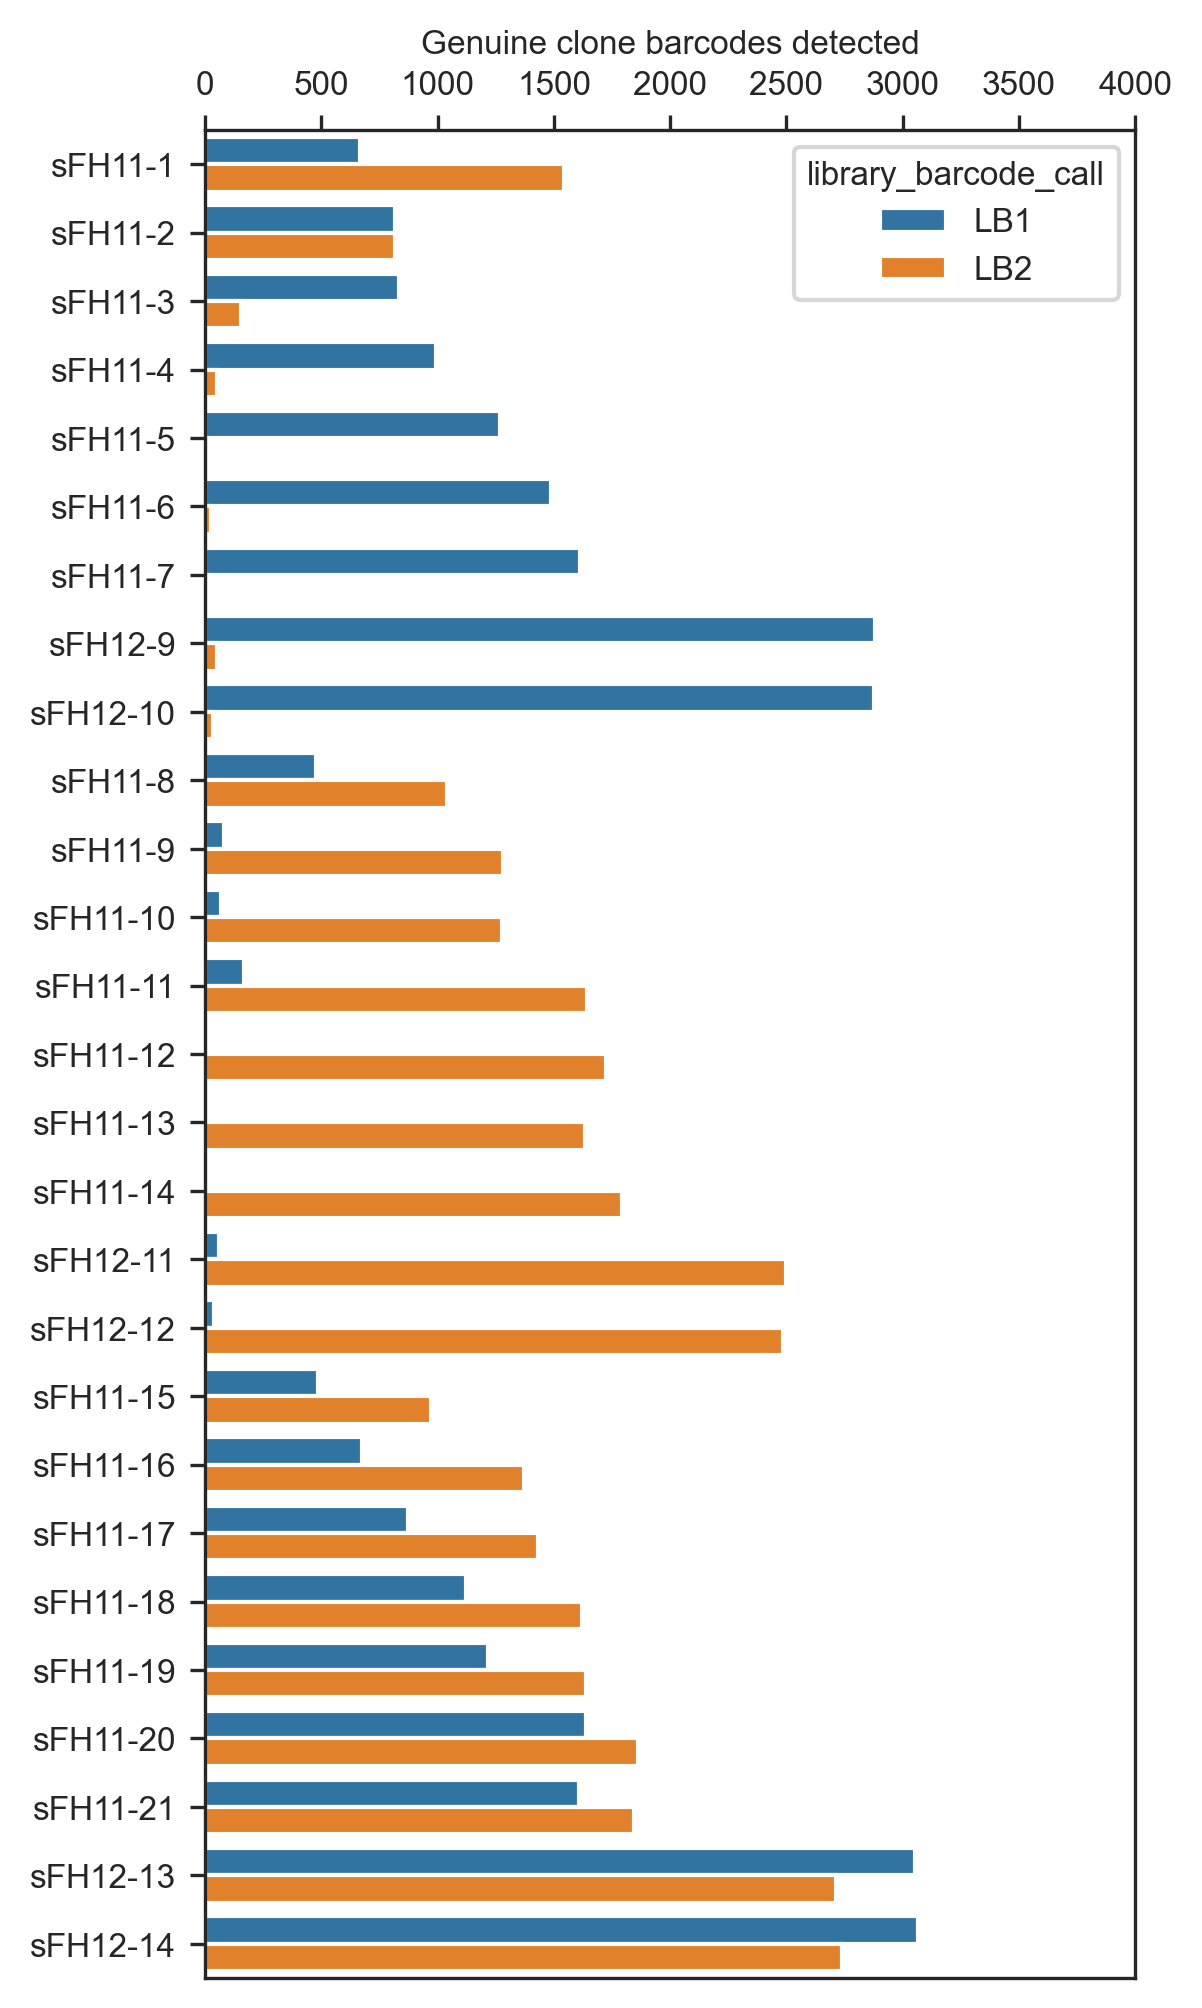

In [36]:
# Raw calls

data = clones_clean_raw.groupby(["lib", "library_barcode_call"])["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "count"}, axis=1)
data = data.set_index("lib").loc[libs_ordered_by_well].reset_index()  # re-order

fig, ax = plt.subplots(1, 1, figsize=(4,8))

sns.barplot(ax=ax, data=data, x="count", y="lib", hue="library_barcode_call")

# ax.set_xscale("log")
# ax.set_xlim(10, 1e4)

ax.set_xlim(0, 4000)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Genuine clone barcodes detected")
ax.set_ylabel("")

data

## Dynamics calls (propagated across timepoints)

,lib,library_barcode_call,count
0,sFH11-1,LB1,823
1,sFH11-1,LB2,1568
2,sFH11-2,LB1,1169
3,sFH11-2,LB2,927
4,sFH11-3,LB1,1040
...,...,...,...
37,sFH11-19,LB2,1919
38,sFH11-20,LB1,1846
39,sFH11-20,LB2,2109
40,sFH11-21,LB1,1890


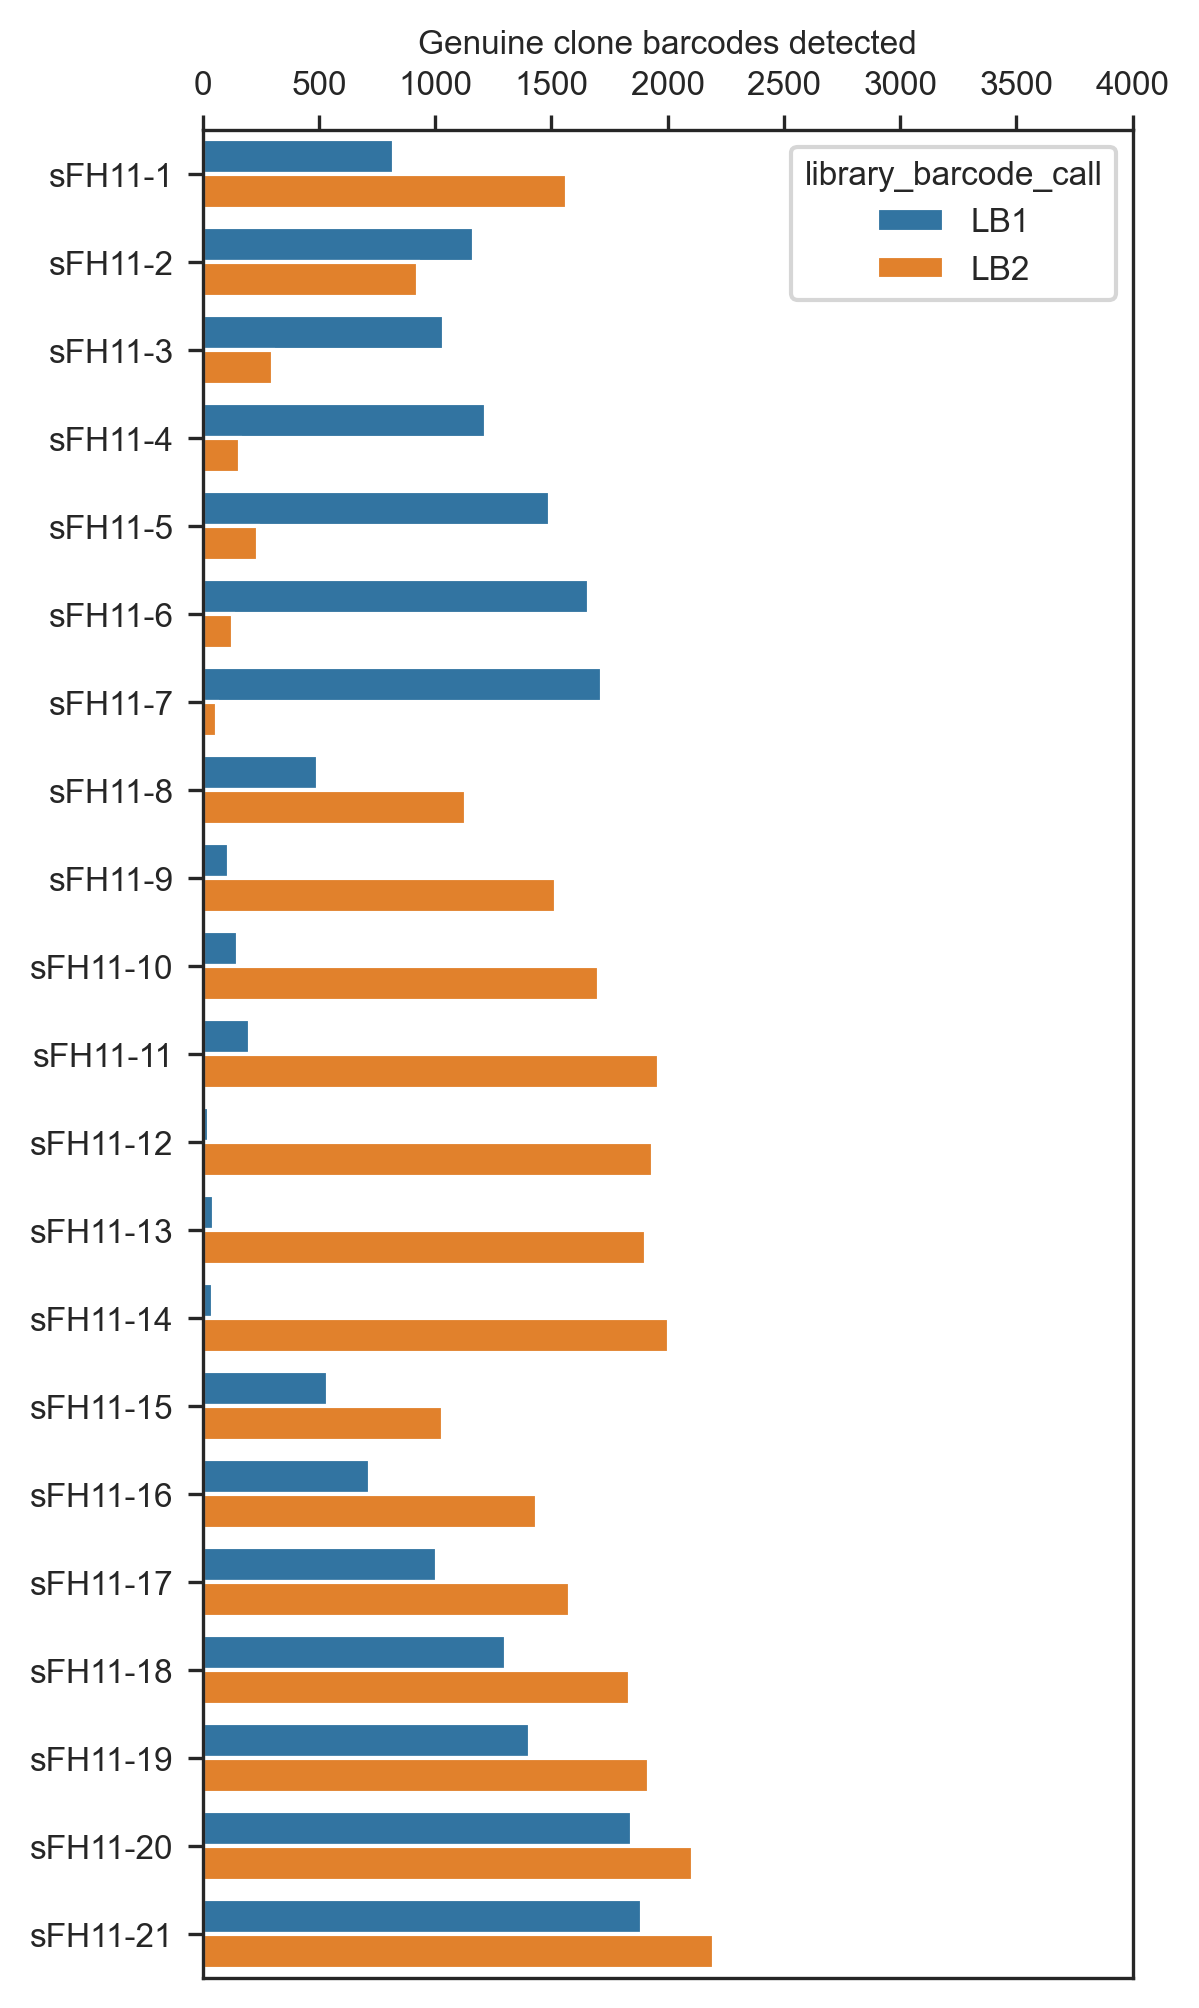

In [37]:
# Dynamics

data = clones_clean_dynamics.groupby(["lib", "library_barcode_call"])["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "count"}, axis=1)
data = data.set_index("lib").loc[libs_ordered_supernatant].reset_index()  # re-order

fig, ax = plt.subplots(1, 1, figsize=(4,8))

sns.barplot(ax=ax, data=data, x="count", y="lib", hue="library_barcode_call")

# ax.set_xscale("log")
# ax.set_xlim(10, 1e4)

ax.set_xlim(0, 4000)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Genuine clone barcodes detected")
ax.set_ylabel("")

data

## Fidelity calls (propagated from cells to supernatant for final timepoint)

,lib,library_barcode_call,count
0,sFH11-6,LB1,1587
1,sFH11-6,LB2,4
2,sFH11-7,LB1,1641
3,sFH11-7,LB2,2
4,sFH12-9,LB1,2935
5,sFH12-9,LB2,53
6,sFH12-10,LB1,2932
7,sFH12-10,LB2,49
8,sFH11-13,LB1,2
9,sFH11-13,LB2,1783


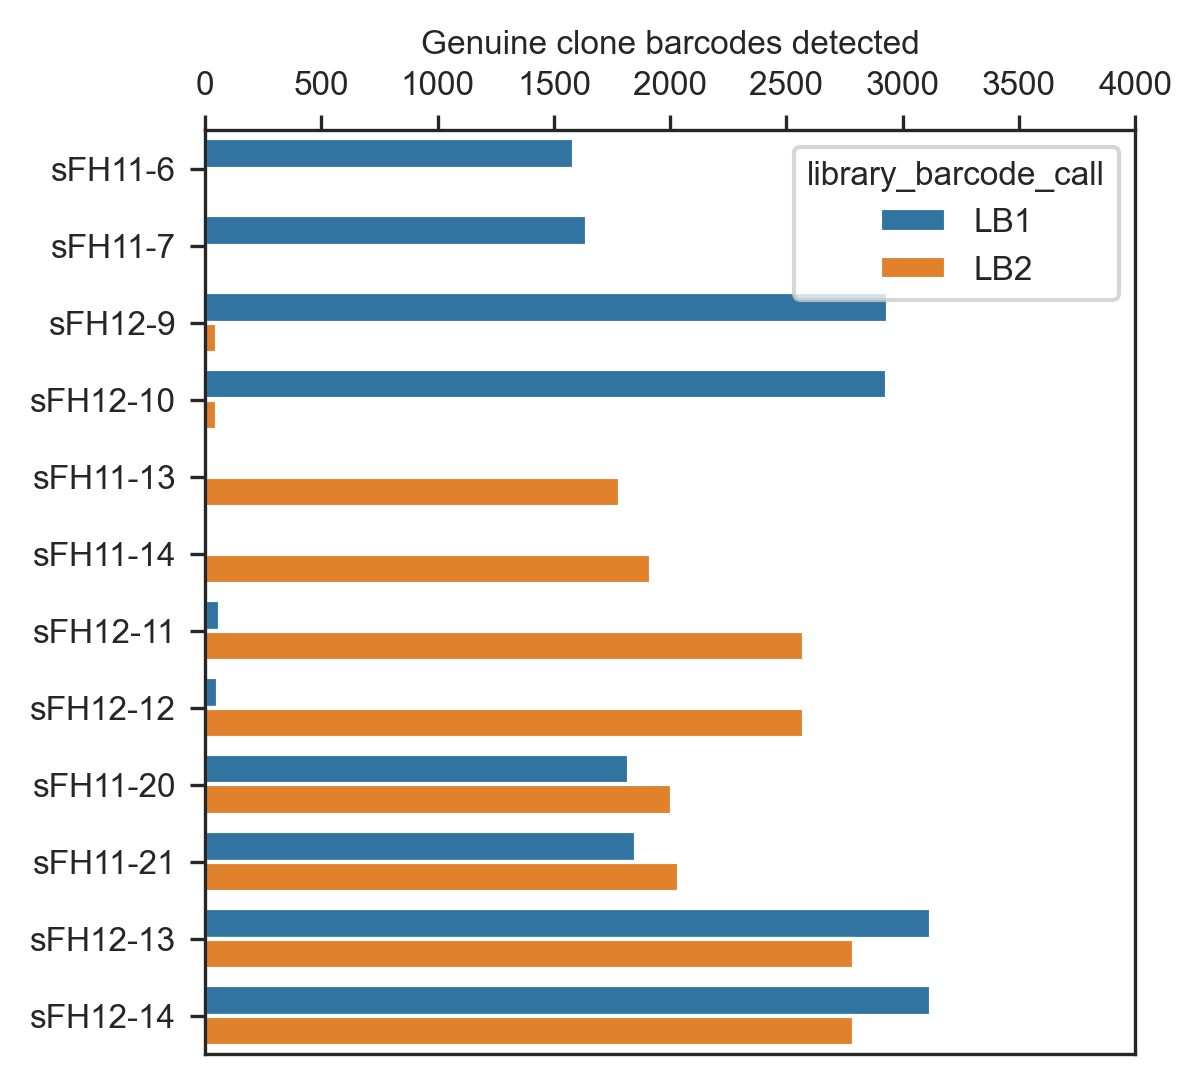

In [38]:
# Fidelity

data = clones_clean_fidelity.groupby(["lib", "library_barcode_call"])["clone_barcode_consensus"].nunique().reset_index()
data = data.rename({"clone_barcode_consensus": "count"}, axis=1)
data = data.set_index("lib").loc[libs_ordered_fidelity].reset_index()  # re-order

fig, ax = plt.subplots(1, 1, figsize=(4,4))

sns.barplot(ax=ax, data=data, x="count", y="lib", hue="library_barcode_call")

# ax.set_xscale("log")
# ax.set_xlim(10, 1e4)

ax.set_xlim(0, 4000)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Genuine clone barcodes detected")
ax.set_ylabel("")

data

# Annotate barcodes with number of timepoints seen

In [39]:
# Calculate number of timepoints where each clone is seen (in supernatant)
n_timepoints_seen = clones.loc[clones["supernatant_or_cells"] == "supernatant"].groupby(["well", "library_barcode_call", "clone_barcode_consensus"])["time"].nunique()

print(n_timepoints_seen.shape)
print(n_timepoints_seen.head())

(1670908,)
well     library_barcode_call  clone_barcode_consensus    
no_drug  LB1                   AAAAAGTCAGTGTCTGTTGCTGACTGA    1
                               AAAAAGTGTGTCAGTGTCACAGACACA    1
                               AAAACCTATGACTGTCTGTCTCAGAAT    1
                               AAAATGACAGTGTATTACTGTGAGTCA    1
                               AAAATGAGAGATTGACTGTCTCAGAGT    1
Name: time, dtype: int64


In [40]:
# Sanity check: here are clone barcodes that are seen repeatedly.
print(n_timepoints_seen.sort_values(ascending=False))

# Take the highest one from this list and check that it's correctly calculated.
clones.loc[clones["clone_barcode_consensus"] == "ACACAGTGTCAGACTGAGTGTCAGAGA"]


well     library_barcode_call  clone_barcode_consensus    
no_drug  LB2                   AGTCTGAGACTGACTGAGACTGTGTCT    6
zeo      LB2                   ACACAGTGTCAGACTGAGTGTCAGAGA    6
puro     LB1                   TGTGTCTCACTGACTGAGTCAGACTGA    6
no_drug  LB1                   ACTCTCAGAGTGTCAGACACTGTCTCT    6
         LB2                   TCAGAGTCTGTGACACACACTGTCAGT    6
                                                             ..
                               AGTGTGAGAGTGACTCTGTCAGACAGT    1
                               AGTGTGAGAGTGACTCTGAGTGTCTGT    1
                               AGTGTGAGAGTGACTCTGACTGTGTGT    1
                               AGTGTGAGAGTGACTCTGACAGACACT    1
zeo      LB2                   TTTTTGTCTGTGTGTGTCACTTAGCCA    1
Name: time, Length: 1670908, dtype: int64


,lib,library_barcode_call,clone_barcode_consensus,count,time,well,supernatant_or_cells,call_genuine_clone_barcode_raw,call_genuine_clone_barcode_dynamics,call_genuine_clone_barcode_fidelity
91145,sFH11-3,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1,2,puro,supernatant,False,False,False
198004,sFH11-6,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,2,5,puro,supernatant,False,False,False
258169,sFH11-8,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,8,0,zeo,supernatant,False,True,False
285927,sFH11-9,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1860,1,zeo,supernatant,True,True,False
336057,sFH11-10,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1466,2,zeo,supernatant,True,True,False
444765,sFH11-11,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1031,3,zeo,supernatant,True,True,False
506125,sFH11-12,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,279,4,zeo,supernatant,True,True,False
565918,sFH11-13,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,243,5,zeo,supernatant,True,True,True
614991,sFH11-14,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1275,5,zeo,supernatant,True,True,True
812148,sFH11-16,LB2,ACACAGTGTCAGACTGAGTGTCAGAGA,1,1,no_drug,supernatant,False,False,False


In [41]:
# Set values in dataframe
clones["n_timepoints_seen"] = -1
clones = clones.set_index(["well", "library_barcode_call", "clone_barcode_consensus"])
clones.loc[n_timepoints_seen.index, "n_timepoints_seen"] = n_timepoints_seen
clones = clones.reset_index()
clones["n_timepoints_seen"] = pd.to_numeric(clones["n_timepoints_seen"], downcast="integer")  # downcast to smallest integer dtype to save memory

# Write results to file

In [42]:
%%time

outfile = "../../../sequencing_data_preprocessing/population_dynamics/clones.error_corrected.genuine_called.tsv.gz"
clones.to_csv(outfile, sep="\t", header=True, index=False)

CPU times: user 1min 33s, sys: 150 ms, total: 1min 33s
Wall time: 1min 33s
